In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_4/models/epoch_28.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_4/data/test_data.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_4/models/epoch_28.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

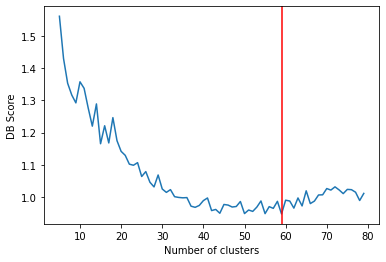

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

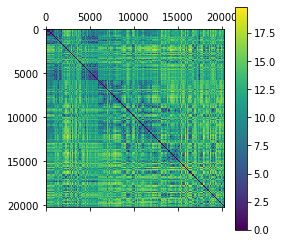

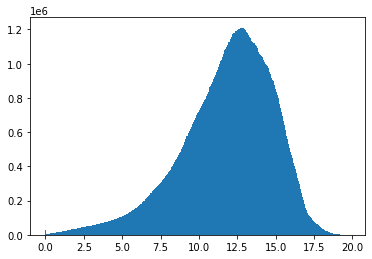

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

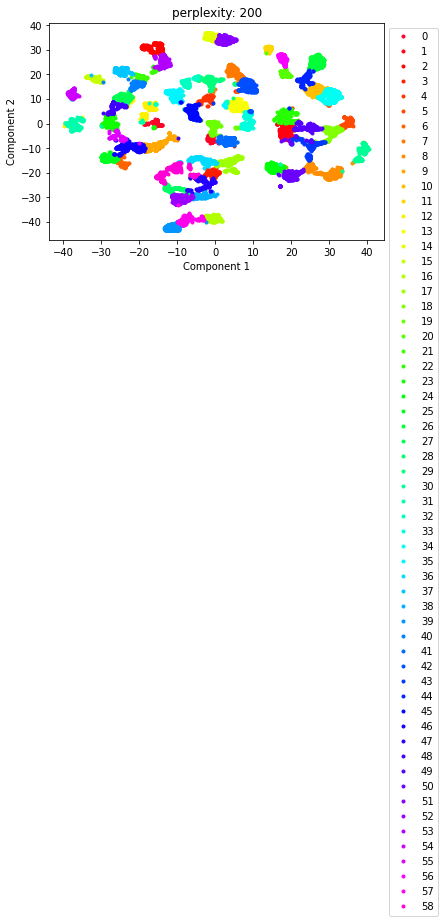

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [39]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 10

In [40]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9351993298181639


In [41]:
losses = []
accs = []
sparsity = []

In [42]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.2938816070165206
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.8653314917127072
layer 4: 0.8653314917127072
layer 5: 0.7726174033149171
layer 6: 0.7108080110497238
layer 7: 0.448118093922652
layer 8: 0.2742791781767956
Epoch: 00 | Batch: 000 / 011 | Total loss: 4.087 | Reg loss: 0.019 | Tree loss: 4.087 | Accuracy: 0.031500 | 0.915 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 4.083 | Reg loss: 0.018 | Tree loss: 4.083 | Accuracy: 0.029000 | 0.882 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 4.080 | Reg loss: 0.018 | Tree loss: 4.080 | Accuracy: 0.027000 | 0.871 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 4.075 | Reg loss: 0.018 | Tree loss: 4.075 | Accuracy: 0.032500 | 0.867 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 4.073 | Reg loss: 0.018 | Tree loss: 4.073 | Accuracy: 0.024500 | 0.867 sec/iter
Epoch: 00 | Batch: 005 / 011 | Total loss: 4.071 | Reg loss: 0.017 | Tree loss: 4.071 | Accur

Epoch: 05 | Batch: 000 / 011 | Total loss: 4.061 | Reg loss: 0.014 | Tree loss: 4.061 | Accuracy: 0.055500 | 0.866 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 4.050 | Reg loss: 0.014 | Tree loss: 4.050 | Accuracy: 0.074000 | 0.866 sec/iter
Epoch: 05 | Batch: 002 / 011 | Total loss: 4.035 | Reg loss: 0.015 | Tree loss: 4.035 | Accuracy: 0.060500 | 0.866 sec/iter
Epoch: 05 | Batch: 003 / 011 | Total loss: 4.018 | Reg loss: 0.015 | Tree loss: 4.018 | Accuracy: 0.058000 | 0.866 sec/iter
Epoch: 05 | Batch: 004 / 011 | Total loss: 4.001 | Reg loss: 0.015 | Tree loss: 4.001 | Accuracy: 0.050500 | 0.865 sec/iter
Epoch: 05 | Batch: 005 / 011 | Total loss: 3.979 | Reg loss: 0.015 | Tree loss: 3.979 | Accuracy: 0.054000 | 0.866 sec/iter
Epoch: 05 | Batch: 006 / 011 | Total loss: 3.965 | Reg loss: 0.015 | Tree loss: 3.965 | Accuracy: 0.047000 | 0.866 sec/iter
Epoch: 05 | Batch: 007 / 011 | Total loss: 3.956 | Reg loss: 0.015 | Tree loss: 3.956 | Accuracy: 0.041500 | 0.866 sec/iter
Epoch: 0

Epoch: 10 | Batch: 000 / 011 | Total loss: 3.973 | Reg loss: 0.016 | Tree loss: 3.973 | Accuracy: 0.075000 | 0.867 sec/iter
Epoch: 10 | Batch: 001 / 011 | Total loss: 3.945 | Reg loss: 0.016 | Tree loss: 3.945 | Accuracy: 0.058000 | 0.866 sec/iter
Epoch: 10 | Batch: 002 / 011 | Total loss: 3.902 | Reg loss: 0.016 | Tree loss: 3.902 | Accuracy: 0.059000 | 0.866 sec/iter
Epoch: 10 | Batch: 003 / 011 | Total loss: 3.859 | Reg loss: 0.016 | Tree loss: 3.859 | Accuracy: 0.067000 | 0.866 sec/iter
Epoch: 10 | Batch: 004 / 011 | Total loss: 3.818 | Reg loss: 0.016 | Tree loss: 3.818 | Accuracy: 0.062500 | 0.866 sec/iter
Epoch: 10 | Batch: 005 / 011 | Total loss: 3.796 | Reg loss: 0.017 | Tree loss: 3.796 | Accuracy: 0.063500 | 0.866 sec/iter
Epoch: 10 | Batch: 006 / 011 | Total loss: 3.767 | Reg loss: 0.017 | Tree loss: 3.767 | Accuracy: 0.054000 | 0.866 sec/iter
Epoch: 10 | Batch: 007 / 011 | Total loss: 3.743 | Reg loss: 0.017 | Tree loss: 3.743 | Accuracy: 0.071000 | 0.866 sec/iter
Epoch: 1

Epoch: 15 | Batch: 000 / 011 | Total loss: 3.754 | Reg loss: 0.019 | Tree loss: 3.754 | Accuracy: 0.088500 | 0.867 sec/iter
Epoch: 15 | Batch: 001 / 011 | Total loss: 3.723 | Reg loss: 0.019 | Tree loss: 3.723 | Accuracy: 0.087000 | 0.867 sec/iter
Epoch: 15 | Batch: 002 / 011 | Total loss: 3.667 | Reg loss: 0.019 | Tree loss: 3.667 | Accuracy: 0.099500 | 0.867 sec/iter
Epoch: 15 | Batch: 003 / 011 | Total loss: 3.632 | Reg loss: 0.019 | Tree loss: 3.632 | Accuracy: 0.091000 | 0.867 sec/iter
Epoch: 15 | Batch: 004 / 011 | Total loss: 3.569 | Reg loss: 0.019 | Tree loss: 3.569 | Accuracy: 0.100000 | 0.867 sec/iter
Epoch: 15 | Batch: 005 / 011 | Total loss: 3.540 | Reg loss: 0.019 | Tree loss: 3.540 | Accuracy: 0.113000 | 0.867 sec/iter
Epoch: 15 | Batch: 006 / 011 | Total loss: 3.515 | Reg loss: 0.019 | Tree loss: 3.515 | Accuracy: 0.121000 | 0.867 sec/iter
Epoch: 15 | Batch: 007 / 011 | Total loss: 3.489 | Reg loss: 0.020 | Tree loss: 3.489 | Accuracy: 0.095500 | 0.867 sec/iter
Epoch: 1

Epoch: 20 | Batch: 000 / 011 | Total loss: 3.529 | Reg loss: 0.021 | Tree loss: 3.529 | Accuracy: 0.143000 | 0.868 sec/iter
Epoch: 20 | Batch: 001 / 011 | Total loss: 3.502 | Reg loss: 0.021 | Tree loss: 3.502 | Accuracy: 0.130000 | 0.868 sec/iter
Epoch: 20 | Batch: 002 / 011 | Total loss: 3.470 | Reg loss: 0.021 | Tree loss: 3.470 | Accuracy: 0.136000 | 0.868 sec/iter
Epoch: 20 | Batch: 003 / 011 | Total loss: 3.417 | Reg loss: 0.021 | Tree loss: 3.417 | Accuracy: 0.128500 | 0.868 sec/iter
Epoch: 20 | Batch: 004 / 011 | Total loss: 3.362 | Reg loss: 0.021 | Tree loss: 3.362 | Accuracy: 0.143000 | 0.868 sec/iter
Epoch: 20 | Batch: 005 / 011 | Total loss: 3.333 | Reg loss: 0.021 | Tree loss: 3.333 | Accuracy: 0.137500 | 0.868 sec/iter
Epoch: 20 | Batch: 006 / 011 | Total loss: 3.296 | Reg loss: 0.021 | Tree loss: 3.296 | Accuracy: 0.141500 | 0.868 sec/iter
Epoch: 20 | Batch: 007 / 011 | Total loss: 3.283 | Reg loss: 0.021 | Tree loss: 3.283 | Accuracy: 0.135000 | 0.868 sec/iter
Epoch: 2

Epoch: 25 | Batch: 000 / 011 | Total loss: 3.377 | Reg loss: 0.023 | Tree loss: 3.377 | Accuracy: 0.141000 | 0.868 sec/iter
Epoch: 25 | Batch: 001 / 011 | Total loss: 3.332 | Reg loss: 0.023 | Tree loss: 3.332 | Accuracy: 0.162500 | 0.868 sec/iter
Epoch: 25 | Batch: 002 / 011 | Total loss: 3.307 | Reg loss: 0.023 | Tree loss: 3.307 | Accuracy: 0.127000 | 0.868 sec/iter
Epoch: 25 | Batch: 003 / 011 | Total loss: 3.251 | Reg loss: 0.023 | Tree loss: 3.251 | Accuracy: 0.129000 | 0.868 sec/iter
Epoch: 25 | Batch: 004 / 011 | Total loss: 3.222 | Reg loss: 0.023 | Tree loss: 3.222 | Accuracy: 0.147000 | 0.868 sec/iter
Epoch: 25 | Batch: 005 / 011 | Total loss: 3.199 | Reg loss: 0.023 | Tree loss: 3.199 | Accuracy: 0.149000 | 0.868 sec/iter
Epoch: 25 | Batch: 006 / 011 | Total loss: 3.161 | Reg loss: 0.023 | Tree loss: 3.161 | Accuracy: 0.190000 | 0.868 sec/iter
Epoch: 25 | Batch: 007 / 011 | Total loss: 3.154 | Reg loss: 0.023 | Tree loss: 3.154 | Accuracy: 0.168500 | 0.868 sec/iter
Epoch: 2

Epoch: 30 | Batch: 000 / 011 | Total loss: 3.282 | Reg loss: 0.024 | Tree loss: 3.282 | Accuracy: 0.127000 | 0.868 sec/iter
Epoch: 30 | Batch: 001 / 011 | Total loss: 3.241 | Reg loss: 0.024 | Tree loss: 3.241 | Accuracy: 0.124000 | 0.868 sec/iter
Epoch: 30 | Batch: 002 / 011 | Total loss: 3.203 | Reg loss: 0.024 | Tree loss: 3.203 | Accuracy: 0.122500 | 0.868 sec/iter
Epoch: 30 | Batch: 003 / 011 | Total loss: 3.153 | Reg loss: 0.024 | Tree loss: 3.153 | Accuracy: 0.131000 | 0.868 sec/iter
Epoch: 30 | Batch: 004 / 011 | Total loss: 3.123 | Reg loss: 0.024 | Tree loss: 3.123 | Accuracy: 0.157000 | 0.868 sec/iter
Epoch: 30 | Batch: 005 / 011 | Total loss: 3.100 | Reg loss: 0.024 | Tree loss: 3.100 | Accuracy: 0.177500 | 0.868 sec/iter
Epoch: 30 | Batch: 006 / 011 | Total loss: 3.055 | Reg loss: 0.024 | Tree loss: 3.055 | Accuracy: 0.187500 | 0.868 sec/iter
Epoch: 30 | Batch: 007 / 011 | Total loss: 3.040 | Reg loss: 0.024 | Tree loss: 3.040 | Accuracy: 0.201000 | 0.868 sec/iter
Epoch: 3

Epoch: 35 | Batch: 000 / 011 | Total loss: 3.186 | Reg loss: 0.025 | Tree loss: 3.186 | Accuracy: 0.123000 | 0.868 sec/iter
Epoch: 35 | Batch: 001 / 011 | Total loss: 3.167 | Reg loss: 0.025 | Tree loss: 3.167 | Accuracy: 0.124000 | 0.868 sec/iter
Epoch: 35 | Batch: 002 / 011 | Total loss: 3.118 | Reg loss: 0.025 | Tree loss: 3.118 | Accuracy: 0.130500 | 0.868 sec/iter
Epoch: 35 | Batch: 003 / 011 | Total loss: 3.096 | Reg loss: 0.025 | Tree loss: 3.096 | Accuracy: 0.125000 | 0.868 sec/iter
Epoch: 35 | Batch: 004 / 011 | Total loss: 3.063 | Reg loss: 0.026 | Tree loss: 3.063 | Accuracy: 0.129500 | 0.868 sec/iter
Epoch: 35 | Batch: 005 / 011 | Total loss: 3.018 | Reg loss: 0.026 | Tree loss: 3.018 | Accuracy: 0.171000 | 0.868 sec/iter
Epoch: 35 | Batch: 006 / 011 | Total loss: 3.006 | Reg loss: 0.026 | Tree loss: 3.006 | Accuracy: 0.177000 | 0.868 sec/iter
Epoch: 35 | Batch: 007 / 011 | Total loss: 2.959 | Reg loss: 0.026 | Tree loss: 2.959 | Accuracy: 0.212500 | 0.868 sec/iter
Epoch: 3

Epoch: 40 | Batch: 000 / 011 | Total loss: 3.158 | Reg loss: 0.026 | Tree loss: 3.158 | Accuracy: 0.115500 | 0.868 sec/iter
Epoch: 40 | Batch: 001 / 011 | Total loss: 3.095 | Reg loss: 0.027 | Tree loss: 3.095 | Accuracy: 0.126000 | 0.868 sec/iter
Epoch: 40 | Batch: 002 / 011 | Total loss: 3.083 | Reg loss: 0.027 | Tree loss: 3.083 | Accuracy: 0.140000 | 0.868 sec/iter
Epoch: 40 | Batch: 003 / 011 | Total loss: 3.061 | Reg loss: 0.027 | Tree loss: 3.061 | Accuracy: 0.123000 | 0.868 sec/iter
Epoch: 40 | Batch: 004 / 011 | Total loss: 3.005 | Reg loss: 0.027 | Tree loss: 3.005 | Accuracy: 0.153000 | 0.868 sec/iter
Epoch: 40 | Batch: 005 / 011 | Total loss: 2.966 | Reg loss: 0.027 | Tree loss: 2.966 | Accuracy: 0.180500 | 0.868 sec/iter
Epoch: 40 | Batch: 006 / 011 | Total loss: 2.920 | Reg loss: 0.027 | Tree loss: 2.920 | Accuracy: 0.210500 | 0.868 sec/iter
Epoch: 40 | Batch: 007 / 011 | Total loss: 2.904 | Reg loss: 0.027 | Tree loss: 2.904 | Accuracy: 0.222500 | 0.868 sec/iter
Epoch: 4

Epoch: 45 | Batch: 000 / 011 | Total loss: 3.117 | Reg loss: 0.027 | Tree loss: 3.117 | Accuracy: 0.124000 | 0.869 sec/iter
Epoch: 45 | Batch: 001 / 011 | Total loss: 3.077 | Reg loss: 0.027 | Tree loss: 3.077 | Accuracy: 0.128500 | 0.869 sec/iter
Epoch: 45 | Batch: 002 / 011 | Total loss: 3.019 | Reg loss: 0.027 | Tree loss: 3.019 | Accuracy: 0.135000 | 0.869 sec/iter
Epoch: 45 | Batch: 003 / 011 | Total loss: 2.988 | Reg loss: 0.027 | Tree loss: 2.988 | Accuracy: 0.143000 | 0.869 sec/iter
Epoch: 45 | Batch: 004 / 011 | Total loss: 2.958 | Reg loss: 0.027 | Tree loss: 2.958 | Accuracy: 0.168500 | 0.869 sec/iter
Epoch: 45 | Batch: 005 / 011 | Total loss: 2.918 | Reg loss: 0.028 | Tree loss: 2.918 | Accuracy: 0.178500 | 0.869 sec/iter
Epoch: 45 | Batch: 006 / 011 | Total loss: 2.894 | Reg loss: 0.028 | Tree loss: 2.894 | Accuracy: 0.191500 | 0.869 sec/iter
Epoch: 45 | Batch: 007 / 011 | Total loss: 2.861 | Reg loss: 0.028 | Tree loss: 2.861 | Accuracy: 0.229500 | 0.869 sec/iter
Epoch: 4

Epoch: 50 | Batch: 000 / 011 | Total loss: 3.075 | Reg loss: 0.028 | Tree loss: 3.075 | Accuracy: 0.118000 | 0.869 sec/iter
Epoch: 50 | Batch: 001 / 011 | Total loss: 3.019 | Reg loss: 0.028 | Tree loss: 3.019 | Accuracy: 0.131500 | 0.869 sec/iter
Epoch: 50 | Batch: 002 / 011 | Total loss: 3.000 | Reg loss: 0.028 | Tree loss: 3.000 | Accuracy: 0.127000 | 0.869 sec/iter
Epoch: 50 | Batch: 003 / 011 | Total loss: 2.955 | Reg loss: 0.028 | Tree loss: 2.955 | Accuracy: 0.169500 | 0.869 sec/iter
Epoch: 50 | Batch: 004 / 011 | Total loss: 2.930 | Reg loss: 0.028 | Tree loss: 2.930 | Accuracy: 0.184500 | 0.869 sec/iter
Epoch: 50 | Batch: 005 / 011 | Total loss: 2.894 | Reg loss: 0.028 | Tree loss: 2.894 | Accuracy: 0.201500 | 0.869 sec/iter
Epoch: 50 | Batch: 006 / 011 | Total loss: 2.847 | Reg loss: 0.028 | Tree loss: 2.847 | Accuracy: 0.220000 | 0.869 sec/iter
Epoch: 50 | Batch: 007 / 011 | Total loss: 2.826 | Reg loss: 0.028 | Tree loss: 2.826 | Accuracy: 0.214500 | 0.869 sec/iter
Epoch: 5

Epoch: 55 | Batch: 000 / 011 | Total loss: 3.037 | Reg loss: 0.029 | Tree loss: 3.037 | Accuracy: 0.122000 | 0.869 sec/iter
Epoch: 55 | Batch: 001 / 011 | Total loss: 3.007 | Reg loss: 0.029 | Tree loss: 3.007 | Accuracy: 0.136000 | 0.869 sec/iter
Epoch: 55 | Batch: 002 / 011 | Total loss: 2.977 | Reg loss: 0.029 | Tree loss: 2.977 | Accuracy: 0.141500 | 0.869 sec/iter
Epoch: 55 | Batch: 003 / 011 | Total loss: 2.934 | Reg loss: 0.029 | Tree loss: 2.934 | Accuracy: 0.163000 | 0.869 sec/iter
Epoch: 55 | Batch: 004 / 011 | Total loss: 2.882 | Reg loss: 0.029 | Tree loss: 2.882 | Accuracy: 0.191500 | 0.869 sec/iter
Epoch: 55 | Batch: 005 / 011 | Total loss: 2.845 | Reg loss: 0.029 | Tree loss: 2.845 | Accuracy: 0.196500 | 0.869 sec/iter
Epoch: 55 | Batch: 006 / 011 | Total loss: 2.828 | Reg loss: 0.029 | Tree loss: 2.828 | Accuracy: 0.201500 | 0.869 sec/iter
Epoch: 55 | Batch: 007 / 011 | Total loss: 2.821 | Reg loss: 0.029 | Tree loss: 2.821 | Accuracy: 0.219000 | 0.869 sec/iter
Epoch: 5

Epoch: 60 | Batch: 000 / 011 | Total loss: 3.014 | Reg loss: 0.029 | Tree loss: 3.014 | Accuracy: 0.146000 | 0.869 sec/iter
Epoch: 60 | Batch: 001 / 011 | Total loss: 2.962 | Reg loss: 0.029 | Tree loss: 2.962 | Accuracy: 0.143500 | 0.869 sec/iter
Epoch: 60 | Batch: 002 / 011 | Total loss: 2.954 | Reg loss: 0.029 | Tree loss: 2.954 | Accuracy: 0.150500 | 0.869 sec/iter
Epoch: 60 | Batch: 003 / 011 | Total loss: 2.893 | Reg loss: 0.029 | Tree loss: 2.893 | Accuracy: 0.192500 | 0.869 sec/iter
Epoch: 60 | Batch: 004 / 011 | Total loss: 2.853 | Reg loss: 0.029 | Tree loss: 2.853 | Accuracy: 0.195500 | 0.869 sec/iter
Epoch: 60 | Batch: 005 / 011 | Total loss: 2.823 | Reg loss: 0.029 | Tree loss: 2.823 | Accuracy: 0.204000 | 0.869 sec/iter
Epoch: 60 | Batch: 006 / 011 | Total loss: 2.810 | Reg loss: 0.029 | Tree loss: 2.810 | Accuracy: 0.222500 | 0.869 sec/iter
Epoch: 60 | Batch: 007 / 011 | Total loss: 2.785 | Reg loss: 0.029 | Tree loss: 2.785 | Accuracy: 0.209500 | 0.869 sec/iter
Epoch: 6

Epoch: 65 | Batch: 000 / 011 | Total loss: 2.992 | Reg loss: 0.030 | Tree loss: 2.992 | Accuracy: 0.152000 | 0.87 sec/iter
Epoch: 65 | Batch: 001 / 011 | Total loss: 2.968 | Reg loss: 0.030 | Tree loss: 2.968 | Accuracy: 0.133500 | 0.87 sec/iter
Epoch: 65 | Batch: 002 / 011 | Total loss: 2.930 | Reg loss: 0.030 | Tree loss: 2.930 | Accuracy: 0.160000 | 0.87 sec/iter
Epoch: 65 | Batch: 003 / 011 | Total loss: 2.878 | Reg loss: 0.030 | Tree loss: 2.878 | Accuracy: 0.193000 | 0.87 sec/iter
Epoch: 65 | Batch: 004 / 011 | Total loss: 2.853 | Reg loss: 0.030 | Tree loss: 2.853 | Accuracy: 0.200000 | 0.87 sec/iter
Epoch: 65 | Batch: 005 / 011 | Total loss: 2.808 | Reg loss: 0.030 | Tree loss: 2.808 | Accuracy: 0.198000 | 0.87 sec/iter
Epoch: 65 | Batch: 006 / 011 | Total loss: 2.797 | Reg loss: 0.030 | Tree loss: 2.797 | Accuracy: 0.211500 | 0.87 sec/iter
Epoch: 65 | Batch: 007 / 011 | Total loss: 2.748 | Reg loss: 0.030 | Tree loss: 2.748 | Accuracy: 0.235000 | 0.87 sec/iter
Epoch: 65 | Batc

Epoch: 70 | Batch: 000 / 011 | Total loss: 2.955 | Reg loss: 0.030 | Tree loss: 2.955 | Accuracy: 0.170000 | 0.87 sec/iter
Epoch: 70 | Batch: 001 / 011 | Total loss: 2.952 | Reg loss: 0.030 | Tree loss: 2.952 | Accuracy: 0.163500 | 0.87 sec/iter
Epoch: 70 | Batch: 002 / 011 | Total loss: 2.898 | Reg loss: 0.030 | Tree loss: 2.898 | Accuracy: 0.171500 | 0.87 sec/iter
Epoch: 70 | Batch: 003 / 011 | Total loss: 2.868 | Reg loss: 0.030 | Tree loss: 2.868 | Accuracy: 0.188000 | 0.87 sec/iter
Epoch: 70 | Batch: 004 / 011 | Total loss: 2.809 | Reg loss: 0.030 | Tree loss: 2.809 | Accuracy: 0.221500 | 0.87 sec/iter
Epoch: 70 | Batch: 005 / 011 | Total loss: 2.781 | Reg loss: 0.030 | Tree loss: 2.781 | Accuracy: 0.225000 | 0.87 sec/iter
Epoch: 70 | Batch: 006 / 011 | Total loss: 2.777 | Reg loss: 0.030 | Tree loss: 2.777 | Accuracy: 0.226500 | 0.87 sec/iter
Epoch: 70 | Batch: 007 / 011 | Total loss: 2.766 | Reg loss: 0.030 | Tree loss: 2.766 | Accuracy: 0.216500 | 0.871 sec/iter
Epoch: 70 | Bat

Epoch: 75 | Batch: 000 / 011 | Total loss: 2.941 | Reg loss: 0.030 | Tree loss: 2.941 | Accuracy: 0.168000 | 0.872 sec/iter
Epoch: 75 | Batch: 001 / 011 | Total loss: 2.940 | Reg loss: 0.030 | Tree loss: 2.940 | Accuracy: 0.170500 | 0.872 sec/iter
Epoch: 75 | Batch: 002 / 011 | Total loss: 2.886 | Reg loss: 0.031 | Tree loss: 2.886 | Accuracy: 0.174500 | 0.872 sec/iter
Epoch: 75 | Batch: 003 / 011 | Total loss: 2.863 | Reg loss: 0.031 | Tree loss: 2.863 | Accuracy: 0.188500 | 0.872 sec/iter
Epoch: 75 | Batch: 004 / 011 | Total loss: 2.815 | Reg loss: 0.031 | Tree loss: 2.815 | Accuracy: 0.187000 | 0.873 sec/iter
Epoch: 75 | Batch: 005 / 011 | Total loss: 2.797 | Reg loss: 0.031 | Tree loss: 2.797 | Accuracy: 0.196500 | 0.873 sec/iter
Epoch: 75 | Batch: 006 / 011 | Total loss: 2.744 | Reg loss: 0.031 | Tree loss: 2.744 | Accuracy: 0.215000 | 0.874 sec/iter
Epoch: 75 | Batch: 007 / 011 | Total loss: 2.701 | Reg loss: 0.031 | Tree loss: 2.701 | Accuracy: 0.255000 | 0.874 sec/iter
Epoch: 7

Epoch: 80 | Batch: 000 / 011 | Total loss: 2.957 | Reg loss: 0.031 | Tree loss: 2.957 | Accuracy: 0.175000 | 0.881 sec/iter
Epoch: 80 | Batch: 001 / 011 | Total loss: 2.873 | Reg loss: 0.031 | Tree loss: 2.873 | Accuracy: 0.181000 | 0.881 sec/iter
Epoch: 80 | Batch: 002 / 011 | Total loss: 2.864 | Reg loss: 0.031 | Tree loss: 2.864 | Accuracy: 0.196000 | 0.881 sec/iter
Epoch: 80 | Batch: 003 / 011 | Total loss: 2.817 | Reg loss: 0.031 | Tree loss: 2.817 | Accuracy: 0.189500 | 0.881 sec/iter
Epoch: 80 | Batch: 004 / 011 | Total loss: 2.815 | Reg loss: 0.031 | Tree loss: 2.815 | Accuracy: 0.216500 | 0.881 sec/iter
Epoch: 80 | Batch: 005 / 011 | Total loss: 2.761 | Reg loss: 0.031 | Tree loss: 2.761 | Accuracy: 0.226500 | 0.881 sec/iter
Epoch: 80 | Batch: 006 / 011 | Total loss: 2.751 | Reg loss: 0.031 | Tree loss: 2.751 | Accuracy: 0.223500 | 0.882 sec/iter
Epoch: 80 | Batch: 007 / 011 | Total loss: 2.700 | Reg loss: 0.031 | Tree loss: 2.700 | Accuracy: 0.218000 | 0.882 sec/iter
Epoch: 8

Epoch: 85 | Batch: 000 / 011 | Total loss: 2.948 | Reg loss: 0.031 | Tree loss: 2.948 | Accuracy: 0.167500 | 0.888 sec/iter
Epoch: 85 | Batch: 001 / 011 | Total loss: 2.912 | Reg loss: 0.031 | Tree loss: 2.912 | Accuracy: 0.170500 | 0.888 sec/iter
Epoch: 85 | Batch: 002 / 011 | Total loss: 2.873 | Reg loss: 0.031 | Tree loss: 2.873 | Accuracy: 0.189000 | 0.888 sec/iter
Epoch: 85 | Batch: 003 / 011 | Total loss: 2.828 | Reg loss: 0.031 | Tree loss: 2.828 | Accuracy: 0.200500 | 0.888 sec/iter
Epoch: 85 | Batch: 004 / 011 | Total loss: 2.785 | Reg loss: 0.031 | Tree loss: 2.785 | Accuracy: 0.187000 | 0.889 sec/iter
Epoch: 85 | Batch: 005 / 011 | Total loss: 2.772 | Reg loss: 0.031 | Tree loss: 2.772 | Accuracy: 0.207500 | 0.889 sec/iter
Epoch: 85 | Batch: 006 / 011 | Total loss: 2.737 | Reg loss: 0.031 | Tree loss: 2.737 | Accuracy: 0.227000 | 0.89 sec/iter
Epoch: 85 | Batch: 007 / 011 | Total loss: 2.700 | Reg loss: 0.031 | Tree loss: 2.700 | Accuracy: 0.221500 | 0.891 sec/iter
Epoch: 85

Epoch: 90 | Batch: 000 / 011 | Total loss: 2.931 | Reg loss: 0.031 | Tree loss: 2.931 | Accuracy: 0.165500 | 0.919 sec/iter
Epoch: 90 | Batch: 001 / 011 | Total loss: 2.864 | Reg loss: 0.031 | Tree loss: 2.864 | Accuracy: 0.185000 | 0.919 sec/iter
Epoch: 90 | Batch: 002 / 011 | Total loss: 2.866 | Reg loss: 0.031 | Tree loss: 2.866 | Accuracy: 0.187000 | 0.92 sec/iter
Epoch: 90 | Batch: 003 / 011 | Total loss: 2.823 | Reg loss: 0.031 | Tree loss: 2.823 | Accuracy: 0.187000 | 0.921 sec/iter
Epoch: 90 | Batch: 004 / 011 | Total loss: 2.772 | Reg loss: 0.031 | Tree loss: 2.772 | Accuracy: 0.202500 | 0.921 sec/iter
Epoch: 90 | Batch: 005 / 011 | Total loss: 2.724 | Reg loss: 0.031 | Tree loss: 2.724 | Accuracy: 0.223000 | 0.921 sec/iter
Epoch: 90 | Batch: 006 / 011 | Total loss: 2.699 | Reg loss: 0.031 | Tree loss: 2.699 | Accuracy: 0.224500 | 0.922 sec/iter
Epoch: 90 | Batch: 007 / 011 | Total loss: 2.699 | Reg loss: 0.031 | Tree loss: 2.699 | Accuracy: 0.220000 | 0.923 sec/iter
Epoch: 90

Epoch: 95 | Batch: 000 / 011 | Total loss: 2.901 | Reg loss: 0.031 | Tree loss: 2.901 | Accuracy: 0.165000 | 0.949 sec/iter
Epoch: 95 | Batch: 001 / 011 | Total loss: 2.896 | Reg loss: 0.031 | Tree loss: 2.896 | Accuracy: 0.172000 | 0.95 sec/iter
Epoch: 95 | Batch: 002 / 011 | Total loss: 2.820 | Reg loss: 0.031 | Tree loss: 2.820 | Accuracy: 0.180000 | 0.95 sec/iter
Epoch: 95 | Batch: 003 / 011 | Total loss: 2.801 | Reg loss: 0.031 | Tree loss: 2.801 | Accuracy: 0.194500 | 0.951 sec/iter
Epoch: 95 | Batch: 004 / 011 | Total loss: 2.761 | Reg loss: 0.031 | Tree loss: 2.761 | Accuracy: 0.199000 | 0.951 sec/iter
Epoch: 95 | Batch: 005 / 011 | Total loss: 2.741 | Reg loss: 0.031 | Tree loss: 2.741 | Accuracy: 0.203000 | 0.952 sec/iter
Epoch: 95 | Batch: 006 / 011 | Total loss: 2.698 | Reg loss: 0.031 | Tree loss: 2.698 | Accuracy: 0.215000 | 0.953 sec/iter
Epoch: 95 | Batch: 007 / 011 | Total loss: 2.688 | Reg loss: 0.032 | Tree loss: 2.688 | Accuracy: 0.215000 | 0.953 sec/iter
Epoch: 95 

Epoch: 100 | Batch: 000 / 011 | Total loss: 2.899 | Reg loss: 0.032 | Tree loss: 2.899 | Accuracy: 0.151500 | 0.979 sec/iter
Epoch: 100 | Batch: 001 / 011 | Total loss: 2.873 | Reg loss: 0.032 | Tree loss: 2.873 | Accuracy: 0.150000 | 0.98 sec/iter
Epoch: 100 | Batch: 002 / 011 | Total loss: 2.803 | Reg loss: 0.032 | Tree loss: 2.803 | Accuracy: 0.168000 | 0.98 sec/iter
Epoch: 100 | Batch: 003 / 011 | Total loss: 2.793 | Reg loss: 0.032 | Tree loss: 2.793 | Accuracy: 0.160000 | 0.981 sec/iter
Epoch: 100 | Batch: 004 / 011 | Total loss: 2.758 | Reg loss: 0.032 | Tree loss: 2.758 | Accuracy: 0.186500 | 0.981 sec/iter
Epoch: 100 | Batch: 005 / 011 | Total loss: 2.732 | Reg loss: 0.032 | Tree loss: 2.732 | Accuracy: 0.200500 | 0.982 sec/iter
Epoch: 100 | Batch: 006 / 011 | Total loss: 2.687 | Reg loss: 0.032 | Tree loss: 2.687 | Accuracy: 0.209000 | 0.982 sec/iter
Epoch: 100 | Batch: 007 / 011 | Total loss: 2.693 | Reg loss: 0.032 | Tree loss: 2.693 | Accuracy: 0.202000 | 0.983 sec/iter
Ep

Epoch: 105 | Batch: 000 / 011 | Total loss: 2.904 | Reg loss: 0.032 | Tree loss: 2.904 | Accuracy: 0.169500 | 1.005 sec/iter
Epoch: 105 | Batch: 001 / 011 | Total loss: 2.849 | Reg loss: 0.032 | Tree loss: 2.849 | Accuracy: 0.156000 | 1.006 sec/iter
Epoch: 105 | Batch: 002 / 011 | Total loss: 2.826 | Reg loss: 0.032 | Tree loss: 2.826 | Accuracy: 0.172500 | 1.006 sec/iter
Epoch: 105 | Batch: 003 / 011 | Total loss: 2.792 | Reg loss: 0.032 | Tree loss: 2.792 | Accuracy: 0.186000 | 1.007 sec/iter
Epoch: 105 | Batch: 004 / 011 | Total loss: 2.728 | Reg loss: 0.032 | Tree loss: 2.728 | Accuracy: 0.217500 | 1.007 sec/iter
Epoch: 105 | Batch: 005 / 011 | Total loss: 2.726 | Reg loss: 0.032 | Tree loss: 2.726 | Accuracy: 0.199500 | 1.007 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 2.687 | Reg loss: 0.032 | Tree loss: 2.687 | Accuracy: 0.202000 | 1.008 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 2.671 | Reg loss: 0.032 | Tree loss: 2.671 | Accuracy: 0.215000 | 1.008 sec/iter


Epoch: 110 | Batch: 000 / 011 | Total loss: 2.863 | Reg loss: 0.032 | Tree loss: 2.863 | Accuracy: 0.168000 | 1.028 sec/iter
Epoch: 110 | Batch: 001 / 011 | Total loss: 2.843 | Reg loss: 0.032 | Tree loss: 2.843 | Accuracy: 0.154500 | 1.028 sec/iter
Epoch: 110 | Batch: 002 / 011 | Total loss: 2.834 | Reg loss: 0.032 | Tree loss: 2.834 | Accuracy: 0.179000 | 1.028 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 2.791 | Reg loss: 0.032 | Tree loss: 2.791 | Accuracy: 0.185000 | 1.029 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 2.745 | Reg loss: 0.032 | Tree loss: 2.745 | Accuracy: 0.203000 | 1.029 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 2.683 | Reg loss: 0.032 | Tree loss: 2.683 | Accuracy: 0.203500 | 1.03 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 2.687 | Reg loss: 0.032 | Tree loss: 2.687 | Accuracy: 0.221000 | 1.03 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 2.706 | Reg loss: 0.032 | Tree loss: 2.706 | Accuracy: 0.183000 | 1.031 sec/iter
Ep

Epoch: 115 | Batch: 000 / 011 | Total loss: 2.871 | Reg loss: 0.032 | Tree loss: 2.871 | Accuracy: 0.167000 | 1.053 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 2.858 | Reg loss: 0.032 | Tree loss: 2.858 | Accuracy: 0.167000 | 1.054 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 2.792 | Reg loss: 0.032 | Tree loss: 2.792 | Accuracy: 0.172500 | 1.054 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 2.757 | Reg loss: 0.032 | Tree loss: 2.757 | Accuracy: 0.186500 | 1.054 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 2.767 | Reg loss: 0.032 | Tree loss: 2.767 | Accuracy: 0.193500 | 1.055 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 2.702 | Reg loss: 0.032 | Tree loss: 2.702 | Accuracy: 0.195500 | 1.056 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 2.672 | Reg loss: 0.032 | Tree loss: 2.672 | Accuracy: 0.210500 | 1.056 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 2.671 | Reg loss: 0.032 | Tree loss: 2.671 | Accuracy: 0.206500 | 1.057 sec/iter


Epoch: 120 | Batch: 000 / 011 | Total loss: 2.865 | Reg loss: 0.032 | Tree loss: 2.865 | Accuracy: 0.162500 | 1.08 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 2.858 | Reg loss: 0.032 | Tree loss: 2.858 | Accuracy: 0.164500 | 1.08 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 2.807 | Reg loss: 0.032 | Tree loss: 2.807 | Accuracy: 0.181500 | 1.08 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 2.728 | Reg loss: 0.032 | Tree loss: 2.728 | Accuracy: 0.213000 | 1.081 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 2.741 | Reg loss: 0.032 | Tree loss: 2.741 | Accuracy: 0.206000 | 1.082 sec/iter
Epoch: 120 | Batch: 005 / 011 | Total loss: 2.702 | Reg loss: 0.032 | Tree loss: 2.702 | Accuracy: 0.202000 | 1.082 sec/iter
Epoch: 120 | Batch: 006 / 011 | Total loss: 2.672 | Reg loss: 0.032 | Tree loss: 2.672 | Accuracy: 0.210000 | 1.082 sec/iter
Epoch: 120 | Batch: 007 / 011 | Total loss: 2.654 | Reg loss: 0.032 | Tree loss: 2.654 | Accuracy: 0.211500 | 1.083 sec/iter
Epo

Epoch: 125 | Batch: 000 / 011 | Total loss: 2.826 | Reg loss: 0.032 | Tree loss: 2.826 | Accuracy: 0.179500 | 1.105 sec/iter
Epoch: 125 | Batch: 001 / 011 | Total loss: 2.810 | Reg loss: 0.032 | Tree loss: 2.810 | Accuracy: 0.186000 | 1.105 sec/iter
Epoch: 125 | Batch: 002 / 011 | Total loss: 2.824 | Reg loss: 0.032 | Tree loss: 2.824 | Accuracy: 0.177000 | 1.106 sec/iter
Epoch: 125 | Batch: 003 / 011 | Total loss: 2.781 | Reg loss: 0.032 | Tree loss: 2.781 | Accuracy: 0.190500 | 1.107 sec/iter
Epoch: 125 | Batch: 004 / 011 | Total loss: 2.741 | Reg loss: 0.032 | Tree loss: 2.741 | Accuracy: 0.210000 | 1.107 sec/iter
Epoch: 125 | Batch: 005 / 011 | Total loss: 2.695 | Reg loss: 0.032 | Tree loss: 2.695 | Accuracy: 0.204500 | 1.107 sec/iter
Epoch: 125 | Batch: 006 / 011 | Total loss: 2.654 | Reg loss: 0.032 | Tree loss: 2.654 | Accuracy: 0.239000 | 1.108 sec/iter
Epoch: 125 | Batch: 007 / 011 | Total loss: 2.651 | Reg loss: 0.032 | Tree loss: 2.651 | Accuracy: 0.206000 | 1.109 sec/iter


Epoch: 130 | Batch: 000 / 011 | Total loss: 2.865 | Reg loss: 0.032 | Tree loss: 2.865 | Accuracy: 0.166500 | 1.128 sec/iter
Epoch: 130 | Batch: 001 / 011 | Total loss: 2.823 | Reg loss: 0.032 | Tree loss: 2.823 | Accuracy: 0.161500 | 1.128 sec/iter
Epoch: 130 | Batch: 002 / 011 | Total loss: 2.793 | Reg loss: 0.032 | Tree loss: 2.793 | Accuracy: 0.176500 | 1.128 sec/iter
Epoch: 130 | Batch: 003 / 011 | Total loss: 2.783 | Reg loss: 0.032 | Tree loss: 2.783 | Accuracy: 0.200500 | 1.129 sec/iter
Epoch: 130 | Batch: 004 / 011 | Total loss: 2.718 | Reg loss: 0.032 | Tree loss: 2.718 | Accuracy: 0.202500 | 1.129 sec/iter
Epoch: 130 | Batch: 005 / 011 | Total loss: 2.666 | Reg loss: 0.032 | Tree loss: 2.666 | Accuracy: 0.224000 | 1.13 sec/iter
Epoch: 130 | Batch: 006 / 011 | Total loss: 2.661 | Reg loss: 0.032 | Tree loss: 2.661 | Accuracy: 0.225500 | 1.13 sec/iter
Epoch: 130 | Batch: 007 / 011 | Total loss: 2.665 | Reg loss: 0.032 | Tree loss: 2.665 | Accuracy: 0.224000 | 1.13 sec/iter
Epo

Epoch: 135 | Batch: 000 / 011 | Total loss: 2.873 | Reg loss: 0.032 | Tree loss: 2.873 | Accuracy: 0.185500 | 1.148 sec/iter
Epoch: 135 | Batch: 001 / 011 | Total loss: 2.815 | Reg loss: 0.032 | Tree loss: 2.815 | Accuracy: 0.179500 | 1.148 sec/iter
Epoch: 135 | Batch: 002 / 011 | Total loss: 2.800 | Reg loss: 0.032 | Tree loss: 2.800 | Accuracy: 0.170500 | 1.149 sec/iter
Epoch: 135 | Batch: 003 / 011 | Total loss: 2.780 | Reg loss: 0.032 | Tree loss: 2.780 | Accuracy: 0.185000 | 1.15 sec/iter
Epoch: 135 | Batch: 004 / 011 | Total loss: 2.703 | Reg loss: 0.032 | Tree loss: 2.703 | Accuracy: 0.212000 | 1.15 sec/iter
Epoch: 135 | Batch: 005 / 011 | Total loss: 2.689 | Reg loss: 0.032 | Tree loss: 2.689 | Accuracy: 0.219500 | 1.151 sec/iter
Epoch: 135 | Batch: 006 / 011 | Total loss: 2.640 | Reg loss: 0.032 | Tree loss: 2.640 | Accuracy: 0.215000 | 1.151 sec/iter
Epoch: 135 | Batch: 007 / 011 | Total loss: 2.691 | Reg loss: 0.032 | Tree loss: 2.691 | Accuracy: 0.197000 | 1.151 sec/iter
Ep

Epoch: 140 | Batch: 000 / 011 | Total loss: 2.864 | Reg loss: 0.032 | Tree loss: 2.864 | Accuracy: 0.175000 | 1.169 sec/iter
Epoch: 140 | Batch: 001 / 011 | Total loss: 2.830 | Reg loss: 0.032 | Tree loss: 2.830 | Accuracy: 0.175500 | 1.169 sec/iter
Epoch: 140 | Batch: 002 / 011 | Total loss: 2.777 | Reg loss: 0.032 | Tree loss: 2.777 | Accuracy: 0.212500 | 1.17 sec/iter
Epoch: 140 | Batch: 003 / 011 | Total loss: 2.765 | Reg loss: 0.032 | Tree loss: 2.765 | Accuracy: 0.198000 | 1.17 sec/iter
Epoch: 140 | Batch: 004 / 011 | Total loss: 2.720 | Reg loss: 0.032 | Tree loss: 2.720 | Accuracy: 0.199000 | 1.17 sec/iter
Epoch: 140 | Batch: 005 / 011 | Total loss: 2.698 | Reg loss: 0.032 | Tree loss: 2.698 | Accuracy: 0.221000 | 1.17 sec/iter
Epoch: 140 | Batch: 006 / 011 | Total loss: 2.668 | Reg loss: 0.032 | Tree loss: 2.668 | Accuracy: 0.209000 | 1.171 sec/iter
Epoch: 140 | Batch: 007 / 011 | Total loss: 2.627 | Reg loss: 0.032 | Tree loss: 2.627 | Accuracy: 0.208500 | 1.172 sec/iter
Epoc

Epoch: 145 | Batch: 000 / 011 | Total loss: 2.870 | Reg loss: 0.032 | Tree loss: 2.870 | Accuracy: 0.161000 | 1.186 sec/iter
Epoch: 145 | Batch: 001 / 011 | Total loss: 2.786 | Reg loss: 0.032 | Tree loss: 2.786 | Accuracy: 0.194500 | 1.187 sec/iter
Epoch: 145 | Batch: 002 / 011 | Total loss: 2.814 | Reg loss: 0.032 | Tree loss: 2.814 | Accuracy: 0.177000 | 1.187 sec/iter
Epoch: 145 | Batch: 003 / 011 | Total loss: 2.748 | Reg loss: 0.032 | Tree loss: 2.748 | Accuracy: 0.185000 | 1.188 sec/iter
Epoch: 145 | Batch: 004 / 011 | Total loss: 2.685 | Reg loss: 0.032 | Tree loss: 2.685 | Accuracy: 0.207500 | 1.188 sec/iter
Epoch: 145 | Batch: 005 / 011 | Total loss: 2.691 | Reg loss: 0.032 | Tree loss: 2.691 | Accuracy: 0.217000 | 1.188 sec/iter
Epoch: 145 | Batch: 006 / 011 | Total loss: 2.652 | Reg loss: 0.032 | Tree loss: 2.652 | Accuracy: 0.217000 | 1.188 sec/iter
Epoch: 145 | Batch: 007 / 011 | Total loss: 2.660 | Reg loss: 0.032 | Tree loss: 2.660 | Accuracy: 0.214500 | 1.189 sec/iter


Epoch: 150 | Batch: 000 / 011 | Total loss: 2.840 | Reg loss: 0.032 | Tree loss: 2.840 | Accuracy: 0.173000 | 1.203 sec/iter
Epoch: 150 | Batch: 001 / 011 | Total loss: 2.823 | Reg loss: 0.032 | Tree loss: 2.823 | Accuracy: 0.171500 | 1.203 sec/iter
Epoch: 150 | Batch: 002 / 011 | Total loss: 2.787 | Reg loss: 0.032 | Tree loss: 2.787 | Accuracy: 0.170000 | 1.203 sec/iter
Epoch: 150 | Batch: 003 / 011 | Total loss: 2.725 | Reg loss: 0.032 | Tree loss: 2.725 | Accuracy: 0.198000 | 1.204 sec/iter
Epoch: 150 | Batch: 004 / 011 | Total loss: 2.705 | Reg loss: 0.032 | Tree loss: 2.705 | Accuracy: 0.203500 | 1.204 sec/iter
Epoch: 150 | Batch: 005 / 011 | Total loss: 2.726 | Reg loss: 0.032 | Tree loss: 2.726 | Accuracy: 0.183000 | 1.204 sec/iter
Epoch: 150 | Batch: 006 / 011 | Total loss: 2.652 | Reg loss: 0.032 | Tree loss: 2.652 | Accuracy: 0.236000 | 1.204 sec/iter
Epoch: 150 | Batch: 007 / 011 | Total loss: 2.634 | Reg loss: 0.032 | Tree loss: 2.634 | Accuracy: 0.221000 | 1.204 sec/iter


Epoch: 155 | Batch: 000 / 011 | Total loss: 2.858 | Reg loss: 0.032 | Tree loss: 2.858 | Accuracy: 0.180000 | 1.217 sec/iter
Epoch: 155 | Batch: 001 / 011 | Total loss: 2.802 | Reg loss: 0.032 | Tree loss: 2.802 | Accuracy: 0.193000 | 1.218 sec/iter
Epoch: 155 | Batch: 002 / 011 | Total loss: 2.773 | Reg loss: 0.032 | Tree loss: 2.773 | Accuracy: 0.187500 | 1.218 sec/iter
Epoch: 155 | Batch: 003 / 011 | Total loss: 2.734 | Reg loss: 0.032 | Tree loss: 2.734 | Accuracy: 0.193500 | 1.218 sec/iter
Epoch: 155 | Batch: 004 / 011 | Total loss: 2.697 | Reg loss: 0.032 | Tree loss: 2.697 | Accuracy: 0.204000 | 1.218 sec/iter
Epoch: 155 | Batch: 005 / 011 | Total loss: 2.680 | Reg loss: 0.032 | Tree loss: 2.680 | Accuracy: 0.194500 | 1.219 sec/iter
Epoch: 155 | Batch: 006 / 011 | Total loss: 2.656 | Reg loss: 0.032 | Tree loss: 2.656 | Accuracy: 0.215500 | 1.219 sec/iter
Epoch: 155 | Batch: 007 / 011 | Total loss: 2.662 | Reg loss: 0.032 | Tree loss: 2.662 | Accuracy: 0.208500 | 1.22 sec/iter
E

Epoch: 160 | Batch: 000 / 011 | Total loss: 2.849 | Reg loss: 0.032 | Tree loss: 2.849 | Accuracy: 0.172500 | 1.233 sec/iter
Epoch: 160 | Batch: 001 / 011 | Total loss: 2.811 | Reg loss: 0.032 | Tree loss: 2.811 | Accuracy: 0.187000 | 1.233 sec/iter
Epoch: 160 | Batch: 002 / 011 | Total loss: 2.754 | Reg loss: 0.032 | Tree loss: 2.754 | Accuracy: 0.216000 | 1.234 sec/iter
Epoch: 160 | Batch: 003 / 011 | Total loss: 2.732 | Reg loss: 0.032 | Tree loss: 2.732 | Accuracy: 0.223000 | 1.234 sec/iter
Epoch: 160 | Batch: 004 / 011 | Total loss: 2.715 | Reg loss: 0.032 | Tree loss: 2.715 | Accuracy: 0.205500 | 1.234 sec/iter
Epoch: 160 | Batch: 005 / 011 | Total loss: 2.695 | Reg loss: 0.032 | Tree loss: 2.695 | Accuracy: 0.204500 | 1.234 sec/iter
Epoch: 160 | Batch: 006 / 011 | Total loss: 2.652 | Reg loss: 0.032 | Tree loss: 2.652 | Accuracy: 0.216500 | 1.235 sec/iter
Epoch: 160 | Batch: 007 / 011 | Total loss: 2.655 | Reg loss: 0.032 | Tree loss: 2.655 | Accuracy: 0.215500 | 1.235 sec/iter


layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
Epoch: 165 | Batch: 000 / 011 | Total loss: 2.822 | Reg loss: 0.032 | Tree loss: 2.822 | Accuracy: 0.174500 | 1.248 sec/iter
Epoch: 165 | Batch: 001 / 011 | Total loss: 2.831 | Reg loss: 0.032 | Tree loss: 2.831 | Accuracy: 0.165500 | 1.248 sec/iter
Epoch: 165 | Batch: 002 / 011 | Total loss: 2.782 | Reg loss: 0.032 | Tree loss: 2.782 | Accuracy: 0.190000 | 1.248 sec/iter
Epoch: 165 | Batch: 003 / 011 | Total loss: 2.719 | Reg loss: 0.032 | Tree loss: 2.719 | Accuracy: 0.221500 | 1.248 sec/iter
Epoch: 165 | Batch: 004 / 011 | Total loss: 2.730 | Reg loss: 0.032 | Tree loss: 2.730 | Accuracy: 0.196000 | 1.249 sec/iter
Epoch: 165 | Batch: 005 / 011 | Total loss: 2.676 | Reg loss: 0.032 | Tree loss: 2.676 | Accuracy: 0.214500 | 1.249 sec/iter
Epoch: 165 | Batch: 006 / 011 | Total loss: 2.648 | Reg loss: 0.032 | Tree loss: 2.648 | Accuracy: 0.218000 | 1.249 sec/iter
Epoch: 165 | Batch: 007 / 011 | Total loss: 2.645 | Reg loss: 0.032 |

Epoch: 170 | Batch: 000 / 011 | Total loss: 2.849 | Reg loss: 0.032 | Tree loss: 2.849 | Accuracy: 0.170500 | 1.269 sec/iter
Epoch: 170 | Batch: 001 / 011 | Total loss: 2.796 | Reg loss: 0.032 | Tree loss: 2.796 | Accuracy: 0.174000 | 1.27 sec/iter
Epoch: 170 | Batch: 002 / 011 | Total loss: 2.776 | Reg loss: 0.032 | Tree loss: 2.776 | Accuracy: 0.181000 | 1.27 sec/iter
Epoch: 170 | Batch: 003 / 011 | Total loss: 2.744 | Reg loss: 0.032 | Tree loss: 2.744 | Accuracy: 0.209000 | 1.271 sec/iter
Epoch: 170 | Batch: 004 / 011 | Total loss: 2.715 | Reg loss: 0.032 | Tree loss: 2.715 | Accuracy: 0.204000 | 1.271 sec/iter
Epoch: 170 | Batch: 005 / 011 | Total loss: 2.685 | Reg loss: 0.032 | Tree loss: 2.685 | Accuracy: 0.205500 | 1.271 sec/iter
Epoch: 170 | Batch: 006 / 011 | Total loss: 2.638 | Reg loss: 0.032 | Tree loss: 2.638 | Accuracy: 0.226500 | 1.272 sec/iter
Epoch: 170 | Batch: 007 / 011 | Total loss: 2.630 | Reg loss: 0.032 | Tree loss: 2.630 | Accuracy: 0.201000 | 1.273 sec/iter
Ep

Epoch: 175 | Batch: 000 / 011 | Total loss: 2.852 | Reg loss: 0.032 | Tree loss: 2.852 | Accuracy: 0.179500 | 1.293 sec/iter
Epoch: 175 | Batch: 001 / 011 | Total loss: 2.801 | Reg loss: 0.032 | Tree loss: 2.801 | Accuracy: 0.202500 | 1.293 sec/iter
Epoch: 175 | Batch: 002 / 011 | Total loss: 2.766 | Reg loss: 0.032 | Tree loss: 2.766 | Accuracy: 0.187000 | 1.294 sec/iter
Epoch: 175 | Batch: 003 / 011 | Total loss: 2.736 | Reg loss: 0.032 | Tree loss: 2.736 | Accuracy: 0.213000 | 1.294 sec/iter
Epoch: 175 | Batch: 004 / 011 | Total loss: 2.692 | Reg loss: 0.032 | Tree loss: 2.692 | Accuracy: 0.199500 | 1.295 sec/iter
Epoch: 175 | Batch: 005 / 011 | Total loss: 2.681 | Reg loss: 0.032 | Tree loss: 2.681 | Accuracy: 0.209000 | 1.296 sec/iter
Epoch: 175 | Batch: 006 / 011 | Total loss: 2.633 | Reg loss: 0.032 | Tree loss: 2.633 | Accuracy: 0.225500 | 1.296 sec/iter
Epoch: 175 | Batch: 007 / 011 | Total loss: 2.652 | Reg loss: 0.032 | Tree loss: 2.652 | Accuracy: 0.210000 | 1.296 sec/iter


Epoch: 180 | Batch: 000 / 011 | Total loss: 2.822 | Reg loss: 0.032 | Tree loss: 2.822 | Accuracy: 0.181500 | 1.325 sec/iter
Epoch: 180 | Batch: 001 / 011 | Total loss: 2.805 | Reg loss: 0.032 | Tree loss: 2.805 | Accuracy: 0.193000 | 1.325 sec/iter
Epoch: 180 | Batch: 002 / 011 | Total loss: 2.756 | Reg loss: 0.032 | Tree loss: 2.756 | Accuracy: 0.201500 | 1.326 sec/iter
Epoch: 180 | Batch: 003 / 011 | Total loss: 2.740 | Reg loss: 0.032 | Tree loss: 2.740 | Accuracy: 0.196500 | 1.326 sec/iter
Epoch: 180 | Batch: 004 / 011 | Total loss: 2.720 | Reg loss: 0.032 | Tree loss: 2.720 | Accuracy: 0.213000 | 1.327 sec/iter
Epoch: 180 | Batch: 005 / 011 | Total loss: 2.667 | Reg loss: 0.032 | Tree loss: 2.667 | Accuracy: 0.220500 | 1.327 sec/iter
Epoch: 180 | Batch: 006 / 011 | Total loss: 2.659 | Reg loss: 0.032 | Tree loss: 2.659 | Accuracy: 0.225000 | 1.328 sec/iter
Epoch: 180 | Batch: 007 / 011 | Total loss: 2.642 | Reg loss: 0.032 | Tree loss: 2.642 | Accuracy: 0.222000 | 1.329 sec/iter


Epoch: 185 | Batch: 000 / 011 | Total loss: 2.845 | Reg loss: 0.032 | Tree loss: 2.845 | Accuracy: 0.195500 | 1.356 sec/iter
Epoch: 185 | Batch: 001 / 011 | Total loss: 2.807 | Reg loss: 0.032 | Tree loss: 2.807 | Accuracy: 0.194500 | 1.357 sec/iter
Epoch: 185 | Batch: 002 / 011 | Total loss: 2.770 | Reg loss: 0.032 | Tree loss: 2.770 | Accuracy: 0.197500 | 1.357 sec/iter
Epoch: 185 | Batch: 003 / 011 | Total loss: 2.732 | Reg loss: 0.032 | Tree loss: 2.732 | Accuracy: 0.206000 | 1.358 sec/iter
Epoch: 185 | Batch: 004 / 011 | Total loss: 2.725 | Reg loss: 0.032 | Tree loss: 2.725 | Accuracy: 0.186000 | 1.359 sec/iter
Epoch: 185 | Batch: 005 / 011 | Total loss: 2.663 | Reg loss: 0.032 | Tree loss: 2.663 | Accuracy: 0.226500 | 1.359 sec/iter
Epoch: 185 | Batch: 006 / 011 | Total loss: 2.638 | Reg loss: 0.032 | Tree loss: 2.638 | Accuracy: 0.217000 | 1.36 sec/iter
Epoch: 185 | Batch: 007 / 011 | Total loss: 2.642 | Reg loss: 0.032 | Tree loss: 2.642 | Accuracy: 0.212000 | 1.36 sec/iter
Ep

Epoch: 190 | Batch: 000 / 011 | Total loss: 2.825 | Reg loss: 0.032 | Tree loss: 2.825 | Accuracy: 0.187000 | 1.387 sec/iter
Epoch: 190 | Batch: 001 / 011 | Total loss: 2.827 | Reg loss: 0.032 | Tree loss: 2.827 | Accuracy: 0.186000 | 1.387 sec/iter
Epoch: 190 | Batch: 002 / 011 | Total loss: 2.741 | Reg loss: 0.032 | Tree loss: 2.741 | Accuracy: 0.207000 | 1.388 sec/iter
Epoch: 190 | Batch: 003 / 011 | Total loss: 2.720 | Reg loss: 0.032 | Tree loss: 2.720 | Accuracy: 0.213500 | 1.388 sec/iter
Epoch: 190 | Batch: 004 / 011 | Total loss: 2.691 | Reg loss: 0.032 | Tree loss: 2.691 | Accuracy: 0.226000 | 1.389 sec/iter
Epoch: 190 | Batch: 005 / 011 | Total loss: 2.697 | Reg loss: 0.032 | Tree loss: 2.697 | Accuracy: 0.202500 | 1.39 sec/iter
Epoch: 190 | Batch: 006 / 011 | Total loss: 2.640 | Reg loss: 0.032 | Tree loss: 2.640 | Accuracy: 0.220500 | 1.39 sec/iter
Epoch: 190 | Batch: 007 / 011 | Total loss: 2.640 | Reg loss: 0.032 | Tree loss: 2.640 | Accuracy: 0.214500 | 1.391 sec/iter
Ep

Epoch: 195 | Batch: 000 / 011 | Total loss: 2.815 | Reg loss: 0.032 | Tree loss: 2.815 | Accuracy: 0.176500 | 1.419 sec/iter
Epoch: 195 | Batch: 001 / 011 | Total loss: 2.800 | Reg loss: 0.032 | Tree loss: 2.800 | Accuracy: 0.198000 | 1.419 sec/iter
Epoch: 195 | Batch: 002 / 011 | Total loss: 2.779 | Reg loss: 0.032 | Tree loss: 2.779 | Accuracy: 0.200500 | 1.419 sec/iter
Epoch: 195 | Batch: 003 / 011 | Total loss: 2.737 | Reg loss: 0.032 | Tree loss: 2.737 | Accuracy: 0.195000 | 1.42 sec/iter
Epoch: 195 | Batch: 004 / 011 | Total loss: 2.721 | Reg loss: 0.032 | Tree loss: 2.721 | Accuracy: 0.213000 | 1.421 sec/iter
Epoch: 195 | Batch: 005 / 011 | Total loss: 2.654 | Reg loss: 0.032 | Tree loss: 2.654 | Accuracy: 0.225500 | 1.421 sec/iter
Epoch: 195 | Batch: 006 / 011 | Total loss: 2.659 | Reg loss: 0.032 | Tree loss: 2.659 | Accuracy: 0.221000 | 1.422 sec/iter
Epoch: 195 | Batch: 007 / 011 | Total loss: 2.614 | Reg loss: 0.032 | Tree loss: 2.614 | Accuracy: 0.217500 | 1.423 sec/iter
E

Epoch: 200 | Batch: 000 / 011 | Total loss: 2.857 | Reg loss: 0.032 | Tree loss: 2.857 | Accuracy: 0.165500 | 1.443 sec/iter
Epoch: 200 | Batch: 001 / 011 | Total loss: 2.766 | Reg loss: 0.032 | Tree loss: 2.766 | Accuracy: 0.202000 | 1.443 sec/iter
Epoch: 200 | Batch: 002 / 011 | Total loss: 2.755 | Reg loss: 0.032 | Tree loss: 2.755 | Accuracy: 0.211000 | 1.444 sec/iter
Epoch: 200 | Batch: 003 / 011 | Total loss: 2.725 | Reg loss: 0.032 | Tree loss: 2.725 | Accuracy: 0.210000 | 1.445 sec/iter
Epoch: 200 | Batch: 004 / 011 | Total loss: 2.693 | Reg loss: 0.032 | Tree loss: 2.693 | Accuracy: 0.202500 | 1.445 sec/iter
Epoch: 200 | Batch: 005 / 011 | Total loss: 2.685 | Reg loss: 0.032 | Tree loss: 2.685 | Accuracy: 0.224000 | 1.446 sec/iter
Epoch: 200 | Batch: 006 / 011 | Total loss: 2.669 | Reg loss: 0.032 | Tree loss: 2.669 | Accuracy: 0.224000 | 1.446 sec/iter
Epoch: 200 | Batch: 007 / 011 | Total loss: 2.638 | Reg loss: 0.032 | Tree loss: 2.638 | Accuracy: 0.202000 | 1.447 sec/iter


Epoch: 205 | Batch: 000 / 011 | Total loss: 2.829 | Reg loss: 0.032 | Tree loss: 2.829 | Accuracy: 0.184500 | 1.471 sec/iter
Epoch: 205 | Batch: 001 / 011 | Total loss: 2.812 | Reg loss: 0.032 | Tree loss: 2.812 | Accuracy: 0.195500 | 1.471 sec/iter
Epoch: 205 | Batch: 002 / 011 | Total loss: 2.769 | Reg loss: 0.032 | Tree loss: 2.769 | Accuracy: 0.200000 | 1.471 sec/iter
Epoch: 205 | Batch: 003 / 011 | Total loss: 2.721 | Reg loss: 0.032 | Tree loss: 2.721 | Accuracy: 0.199000 | 1.471 sec/iter
Epoch: 205 | Batch: 004 / 011 | Total loss: 2.685 | Reg loss: 0.032 | Tree loss: 2.685 | Accuracy: 0.208000 | 1.472 sec/iter
Epoch: 205 | Batch: 005 / 011 | Total loss: 2.666 | Reg loss: 0.032 | Tree loss: 2.666 | Accuracy: 0.205000 | 1.472 sec/iter
Epoch: 205 | Batch: 006 / 011 | Total loss: 2.661 | Reg loss: 0.032 | Tree loss: 2.661 | Accuracy: 0.223500 | 1.472 sec/iter
Epoch: 205 | Batch: 007 / 011 | Total loss: 2.621 | Reg loss: 0.032 | Tree loss: 2.621 | Accuracy: 0.217000 | 1.473 sec/iter


Epoch: 210 | Batch: 000 / 011 | Total loss: 2.840 | Reg loss: 0.032 | Tree loss: 2.840 | Accuracy: 0.182000 | 1.495 sec/iter
Epoch: 210 | Batch: 001 / 011 | Total loss: 2.786 | Reg loss: 0.032 | Tree loss: 2.786 | Accuracy: 0.194500 | 1.496 sec/iter
Epoch: 210 | Batch: 002 / 011 | Total loss: 2.755 | Reg loss: 0.032 | Tree loss: 2.755 | Accuracy: 0.184500 | 1.496 sec/iter
Epoch: 210 | Batch: 003 / 011 | Total loss: 2.747 | Reg loss: 0.032 | Tree loss: 2.747 | Accuracy: 0.179500 | 1.497 sec/iter
Epoch: 210 | Batch: 004 / 011 | Total loss: 2.714 | Reg loss: 0.032 | Tree loss: 2.714 | Accuracy: 0.207000 | 1.497 sec/iter
Epoch: 210 | Batch: 005 / 011 | Total loss: 2.652 | Reg loss: 0.032 | Tree loss: 2.652 | Accuracy: 0.223000 | 1.497 sec/iter
Epoch: 210 | Batch: 006 / 011 | Total loss: 2.664 | Reg loss: 0.032 | Tree loss: 2.664 | Accuracy: 0.228000 | 1.498 sec/iter
Epoch: 210 | Batch: 007 / 011 | Total loss: 2.635 | Reg loss: 0.032 | Tree loss: 2.635 | Accuracy: 0.225000 | 1.498 sec/iter


Epoch: 215 | Batch: 000 / 011 | Total loss: 2.857 | Reg loss: 0.032 | Tree loss: 2.857 | Accuracy: 0.181000 | 1.519 sec/iter
Epoch: 215 | Batch: 001 / 011 | Total loss: 2.772 | Reg loss: 0.032 | Tree loss: 2.772 | Accuracy: 0.207500 | 1.52 sec/iter
Epoch: 215 | Batch: 002 / 011 | Total loss: 2.770 | Reg loss: 0.032 | Tree loss: 2.770 | Accuracy: 0.202000 | 1.52 sec/iter
Epoch: 215 | Batch: 003 / 011 | Total loss: 2.753 | Reg loss: 0.032 | Tree loss: 2.753 | Accuracy: 0.195000 | 1.52 sec/iter
Epoch: 215 | Batch: 004 / 011 | Total loss: 2.659 | Reg loss: 0.032 | Tree loss: 2.659 | Accuracy: 0.222500 | 1.521 sec/iter
Epoch: 215 | Batch: 005 / 011 | Total loss: 2.635 | Reg loss: 0.032 | Tree loss: 2.635 | Accuracy: 0.227500 | 1.521 sec/iter
Epoch: 215 | Batch: 006 / 011 | Total loss: 2.683 | Reg loss: 0.032 | Tree loss: 2.683 | Accuracy: 0.201500 | 1.522 sec/iter
Epoch: 215 | Batch: 007 / 011 | Total loss: 2.628 | Reg loss: 0.032 | Tree loss: 2.628 | Accuracy: 0.218000 | 1.522 sec/iter
Epo

Epoch: 220 | Batch: 000 / 011 | Total loss: 2.839 | Reg loss: 0.032 | Tree loss: 2.839 | Accuracy: 0.179500 | 1.542 sec/iter
Epoch: 220 | Batch: 001 / 011 | Total loss: 2.795 | Reg loss: 0.032 | Tree loss: 2.795 | Accuracy: 0.202000 | 1.542 sec/iter
Epoch: 220 | Batch: 002 / 011 | Total loss: 2.762 | Reg loss: 0.032 | Tree loss: 2.762 | Accuracy: 0.191500 | 1.542 sec/iter
Epoch: 220 | Batch: 003 / 011 | Total loss: 2.723 | Reg loss: 0.032 | Tree loss: 2.723 | Accuracy: 0.197000 | 1.542 sec/iter
Epoch: 220 | Batch: 004 / 011 | Total loss: 2.710 | Reg loss: 0.032 | Tree loss: 2.710 | Accuracy: 0.218000 | 1.542 sec/iter
Epoch: 220 | Batch: 005 / 011 | Total loss: 2.658 | Reg loss: 0.032 | Tree loss: 2.658 | Accuracy: 0.226500 | 1.543 sec/iter
Epoch: 220 | Batch: 006 / 011 | Total loss: 2.627 | Reg loss: 0.032 | Tree loss: 2.627 | Accuracy: 0.216000 | 1.543 sec/iter
Epoch: 220 | Batch: 007 / 011 | Total loss: 2.657 | Reg loss: 0.032 | Tree loss: 2.657 | Accuracy: 0.206000 | 1.543 sec/iter


Epoch: 225 | Batch: 000 / 011 | Total loss: 2.854 | Reg loss: 0.032 | Tree loss: 2.854 | Accuracy: 0.178500 | 1.563 sec/iter
Epoch: 225 | Batch: 001 / 011 | Total loss: 2.800 | Reg loss: 0.032 | Tree loss: 2.800 | Accuracy: 0.191000 | 1.563 sec/iter
Epoch: 225 | Batch: 002 / 011 | Total loss: 2.743 | Reg loss: 0.032 | Tree loss: 2.743 | Accuracy: 0.201500 | 1.563 sec/iter
Epoch: 225 | Batch: 003 / 011 | Total loss: 2.708 | Reg loss: 0.032 | Tree loss: 2.708 | Accuracy: 0.214000 | 1.563 sec/iter
Epoch: 225 | Batch: 004 / 011 | Total loss: 2.697 | Reg loss: 0.032 | Tree loss: 2.697 | Accuracy: 0.205500 | 1.564 sec/iter
Epoch: 225 | Batch: 005 / 011 | Total loss: 2.675 | Reg loss: 0.032 | Tree loss: 2.675 | Accuracy: 0.222000 | 1.564 sec/iter
Epoch: 225 | Batch: 006 / 011 | Total loss: 2.661 | Reg loss: 0.032 | Tree loss: 2.661 | Accuracy: 0.214500 | 1.564 sec/iter
Epoch: 225 | Batch: 007 / 011 | Total loss: 2.642 | Reg loss: 0.032 | Tree loss: 2.642 | Accuracy: 0.211500 | 1.564 sec/iter


Epoch: 230 | Batch: 000 / 011 | Total loss: 2.842 | Reg loss: 0.032 | Tree loss: 2.842 | Accuracy: 0.195500 | 1.58 sec/iter
Epoch: 230 | Batch: 001 / 011 | Total loss: 2.816 | Reg loss: 0.032 | Tree loss: 2.816 | Accuracy: 0.194000 | 1.58 sec/iter
Epoch: 230 | Batch: 002 / 011 | Total loss: 2.756 | Reg loss: 0.032 | Tree loss: 2.756 | Accuracy: 0.191000 | 1.581 sec/iter
Epoch: 230 | Batch: 003 / 011 | Total loss: 2.710 | Reg loss: 0.032 | Tree loss: 2.710 | Accuracy: 0.198000 | 1.581 sec/iter
Epoch: 230 | Batch: 004 / 011 | Total loss: 2.661 | Reg loss: 0.032 | Tree loss: 2.661 | Accuracy: 0.227500 | 1.582 sec/iter
Epoch: 230 | Batch: 005 / 011 | Total loss: 2.640 | Reg loss: 0.032 | Tree loss: 2.640 | Accuracy: 0.226500 | 1.582 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 2.657 | Reg loss: 0.032 | Tree loss: 2.657 | Accuracy: 0.209500 | 1.583 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 2.655 | Reg loss: 0.032 | Tree loss: 2.655 | Accuracy: 0.210000 | 1.583 sec/iter
Ep

Epoch: 235 | Batch: 000 / 011 | Total loss: 2.835 | Reg loss: 0.032 | Tree loss: 2.835 | Accuracy: 0.185500 | 1.601 sec/iter
Epoch: 235 | Batch: 001 / 011 | Total loss: 2.795 | Reg loss: 0.032 | Tree loss: 2.795 | Accuracy: 0.178500 | 1.602 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 2.744 | Reg loss: 0.032 | Tree loss: 2.744 | Accuracy: 0.206000 | 1.602 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 2.730 | Reg loss: 0.032 | Tree loss: 2.730 | Accuracy: 0.203000 | 1.602 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 2.674 | Reg loss: 0.032 | Tree loss: 2.674 | Accuracy: 0.211500 | 1.603 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 2.656 | Reg loss: 0.032 | Tree loss: 2.656 | Accuracy: 0.243000 | 1.603 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 2.661 | Reg loss: 0.032 | Tree loss: 2.661 | Accuracy: 0.224000 | 1.603 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 2.638 | Reg loss: 0.032 | Tree loss: 2.638 | Accuracy: 0.205000 | 1.604 sec/iter


Epoch: 240 | Batch: 000 / 011 | Total loss: 2.826 | Reg loss: 0.032 | Tree loss: 2.826 | Accuracy: 0.192000 | 1.622 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 2.781 | Reg loss: 0.032 | Tree loss: 2.781 | Accuracy: 0.199000 | 1.622 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 2.755 | Reg loss: 0.032 | Tree loss: 2.755 | Accuracy: 0.195000 | 1.623 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 2.747 | Reg loss: 0.032 | Tree loss: 2.747 | Accuracy: 0.203000 | 1.623 sec/iter
Epoch: 240 | Batch: 004 / 011 | Total loss: 2.695 | Reg loss: 0.032 | Tree loss: 2.695 | Accuracy: 0.223500 | 1.624 sec/iter
Epoch: 240 | Batch: 005 / 011 | Total loss: 2.653 | Reg loss: 0.032 | Tree loss: 2.653 | Accuracy: 0.214500 | 1.624 sec/iter
Epoch: 240 | Batch: 006 / 011 | Total loss: 2.657 | Reg loss: 0.032 | Tree loss: 2.657 | Accuracy: 0.223500 | 1.624 sec/iter
Epoch: 240 | Batch: 007 / 011 | Total loss: 2.616 | Reg loss: 0.032 | Tree loss: 2.616 | Accuracy: 0.216000 | 1.625 sec/iter


Epoch: 245 | Batch: 000 / 011 | Total loss: 2.809 | Reg loss: 0.032 | Tree loss: 2.809 | Accuracy: 0.193000 | 1.64 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 2.795 | Reg loss: 0.032 | Tree loss: 2.795 | Accuracy: 0.194000 | 1.64 sec/iter
Epoch: 245 | Batch: 002 / 011 | Total loss: 2.756 | Reg loss: 0.032 | Tree loss: 2.756 | Accuracy: 0.189500 | 1.64 sec/iter
Epoch: 245 | Batch: 003 / 011 | Total loss: 2.744 | Reg loss: 0.032 | Tree loss: 2.744 | Accuracy: 0.199000 | 1.64 sec/iter
Epoch: 245 | Batch: 004 / 011 | Total loss: 2.669 | Reg loss: 0.032 | Tree loss: 2.669 | Accuracy: 0.208000 | 1.64 sec/iter
Epoch: 245 | Batch: 005 / 011 | Total loss: 2.682 | Reg loss: 0.032 | Tree loss: 2.682 | Accuracy: 0.210500 | 1.641 sec/iter
Epoch: 245 | Batch: 006 / 011 | Total loss: 2.659 | Reg loss: 0.032 | Tree loss: 2.659 | Accuracy: 0.214000 | 1.641 sec/iter
Epoch: 245 | Batch: 007 / 011 | Total loss: 2.629 | Reg loss: 0.032 | Tree loss: 2.629 | Accuracy: 0.214500 | 1.641 sec/iter
Epoch

Epoch: 250 | Batch: 000 / 011 | Total loss: 2.802 | Reg loss: 0.032 | Tree loss: 2.802 | Accuracy: 0.205000 | 1.656 sec/iter
Epoch: 250 | Batch: 001 / 011 | Total loss: 2.816 | Reg loss: 0.032 | Tree loss: 2.816 | Accuracy: 0.176500 | 1.656 sec/iter
Epoch: 250 | Batch: 002 / 011 | Total loss: 2.775 | Reg loss: 0.032 | Tree loss: 2.775 | Accuracy: 0.181500 | 1.657 sec/iter
Epoch: 250 | Batch: 003 / 011 | Total loss: 2.724 | Reg loss: 0.032 | Tree loss: 2.724 | Accuracy: 0.204500 | 1.657 sec/iter
Epoch: 250 | Batch: 004 / 011 | Total loss: 2.681 | Reg loss: 0.032 | Tree loss: 2.681 | Accuracy: 0.225500 | 1.657 sec/iter
Epoch: 250 | Batch: 005 / 011 | Total loss: 2.676 | Reg loss: 0.032 | Tree loss: 2.676 | Accuracy: 0.204500 | 1.658 sec/iter
Epoch: 250 | Batch: 006 / 011 | Total loss: 2.632 | Reg loss: 0.032 | Tree loss: 2.632 | Accuracy: 0.212000 | 1.658 sec/iter
Epoch: 250 | Batch: 007 / 011 | Total loss: 2.635 | Reg loss: 0.032 | Tree loss: 2.635 | Accuracy: 0.216000 | 1.658 sec/iter


Epoch: 255 | Batch: 000 / 011 | Total loss: 2.822 | Reg loss: 0.032 | Tree loss: 2.822 | Accuracy: 0.200500 | 1.673 sec/iter
Epoch: 255 | Batch: 001 / 011 | Total loss: 2.783 | Reg loss: 0.032 | Tree loss: 2.783 | Accuracy: 0.193000 | 1.673 sec/iter
Epoch: 255 | Batch: 002 / 011 | Total loss: 2.762 | Reg loss: 0.032 | Tree loss: 2.762 | Accuracy: 0.216500 | 1.673 sec/iter
Epoch: 255 | Batch: 003 / 011 | Total loss: 2.737 | Reg loss: 0.032 | Tree loss: 2.737 | Accuracy: 0.206500 | 1.673 sec/iter
Epoch: 255 | Batch: 004 / 011 | Total loss: 2.679 | Reg loss: 0.032 | Tree loss: 2.679 | Accuracy: 0.224500 | 1.674 sec/iter
Epoch: 255 | Batch: 005 / 011 | Total loss: 2.649 | Reg loss: 0.032 | Tree loss: 2.649 | Accuracy: 0.247500 | 1.674 sec/iter
Epoch: 255 | Batch: 006 / 011 | Total loss: 2.641 | Reg loss: 0.032 | Tree loss: 2.641 | Accuracy: 0.215000 | 1.674 sec/iter
Epoch: 255 | Batch: 007 / 011 | Total loss: 2.620 | Reg loss: 0.032 | Tree loss: 2.620 | Accuracy: 0.211000 | 1.674 sec/iter


Epoch: 260 | Batch: 000 / 011 | Total loss: 2.824 | Reg loss: 0.032 | Tree loss: 2.824 | Accuracy: 0.183500 | 1.689 sec/iter
Epoch: 260 | Batch: 001 / 011 | Total loss: 2.808 | Reg loss: 0.032 | Tree loss: 2.808 | Accuracy: 0.193000 | 1.689 sec/iter
Epoch: 260 | Batch: 002 / 011 | Total loss: 2.760 | Reg loss: 0.032 | Tree loss: 2.760 | Accuracy: 0.197000 | 1.689 sec/iter
Epoch: 260 | Batch: 003 / 011 | Total loss: 2.722 | Reg loss: 0.032 | Tree loss: 2.722 | Accuracy: 0.192500 | 1.69 sec/iter
Epoch: 260 | Batch: 004 / 011 | Total loss: 2.696 | Reg loss: 0.032 | Tree loss: 2.696 | Accuracy: 0.220000 | 1.69 sec/iter
Epoch: 260 | Batch: 005 / 011 | Total loss: 2.670 | Reg loss: 0.032 | Tree loss: 2.670 | Accuracy: 0.222000 | 1.69 sec/iter
Epoch: 260 | Batch: 006 / 011 | Total loss: 2.650 | Reg loss: 0.032 | Tree loss: 2.650 | Accuracy: 0.210000 | 1.691 sec/iter
Epoch: 260 | Batch: 007 / 011 | Total loss: 2.632 | Reg loss: 0.032 | Tree loss: 2.632 | Accuracy: 0.200500 | 1.691 sec/iter
Epo

Epoch: 265 | Batch: 000 / 011 | Total loss: 2.838 | Reg loss: 0.032 | Tree loss: 2.838 | Accuracy: 0.188000 | 1.705 sec/iter
Epoch: 265 | Batch: 001 / 011 | Total loss: 2.791 | Reg loss: 0.032 | Tree loss: 2.791 | Accuracy: 0.196500 | 1.705 sec/iter
Epoch: 265 | Batch: 002 / 011 | Total loss: 2.773 | Reg loss: 0.032 | Tree loss: 2.773 | Accuracy: 0.206500 | 1.706 sec/iter
Epoch: 265 | Batch: 003 / 011 | Total loss: 2.707 | Reg loss: 0.032 | Tree loss: 2.707 | Accuracy: 0.210000 | 1.706 sec/iter
Epoch: 265 | Batch: 004 / 011 | Total loss: 2.705 | Reg loss: 0.032 | Tree loss: 2.705 | Accuracy: 0.206500 | 1.706 sec/iter
Epoch: 265 | Batch: 005 / 011 | Total loss: 2.627 | Reg loss: 0.032 | Tree loss: 2.627 | Accuracy: 0.236500 | 1.706 sec/iter
Epoch: 265 | Batch: 006 / 011 | Total loss: 2.669 | Reg loss: 0.032 | Tree loss: 2.669 | Accuracy: 0.203000 | 1.707 sec/iter
Epoch: 265 | Batch: 007 / 011 | Total loss: 2.599 | Reg loss: 0.032 | Tree loss: 2.599 | Accuracy: 0.224000 | 1.707 sec/iter


Epoch: 270 | Batch: 000 / 011 | Total loss: 2.801 | Reg loss: 0.032 | Tree loss: 2.801 | Accuracy: 0.205000 | 1.72 sec/iter
Epoch: 270 | Batch: 001 / 011 | Total loss: 2.778 | Reg loss: 0.032 | Tree loss: 2.778 | Accuracy: 0.211000 | 1.721 sec/iter
Epoch: 270 | Batch: 002 / 011 | Total loss: 2.782 | Reg loss: 0.032 | Tree loss: 2.782 | Accuracy: 0.190000 | 1.721 sec/iter
Epoch: 270 | Batch: 003 / 011 | Total loss: 2.710 | Reg loss: 0.032 | Tree loss: 2.710 | Accuracy: 0.208000 | 1.721 sec/iter
Epoch: 270 | Batch: 004 / 011 | Total loss: 2.694 | Reg loss: 0.032 | Tree loss: 2.694 | Accuracy: 0.223000 | 1.721 sec/iter
Epoch: 270 | Batch: 005 / 011 | Total loss: 2.672 | Reg loss: 0.032 | Tree loss: 2.672 | Accuracy: 0.218000 | 1.721 sec/iter
Epoch: 270 | Batch: 006 / 011 | Total loss: 2.640 | Reg loss: 0.032 | Tree loss: 2.640 | Accuracy: 0.226000 | 1.722 sec/iter
Epoch: 270 | Batch: 007 / 011 | Total loss: 2.634 | Reg loss: 0.032 | Tree loss: 2.634 | Accuracy: 0.201500 | 1.722 sec/iter
E

Epoch: 275 | Batch: 000 / 011 | Total loss: 2.825 | Reg loss: 0.032 | Tree loss: 2.825 | Accuracy: 0.190500 | 1.734 sec/iter
Epoch: 275 | Batch: 001 / 011 | Total loss: 2.772 | Reg loss: 0.032 | Tree loss: 2.772 | Accuracy: 0.206000 | 1.734 sec/iter
Epoch: 275 | Batch: 002 / 011 | Total loss: 2.775 | Reg loss: 0.032 | Tree loss: 2.775 | Accuracy: 0.204500 | 1.734 sec/iter
Epoch: 275 | Batch: 003 / 011 | Total loss: 2.723 | Reg loss: 0.032 | Tree loss: 2.723 | Accuracy: 0.202500 | 1.734 sec/iter
Epoch: 275 | Batch: 004 / 011 | Total loss: 2.724 | Reg loss: 0.032 | Tree loss: 2.724 | Accuracy: 0.210000 | 1.734 sec/iter
Epoch: 275 | Batch: 005 / 011 | Total loss: 2.657 | Reg loss: 0.032 | Tree loss: 2.657 | Accuracy: 0.236000 | 1.735 sec/iter
Epoch: 275 | Batch: 006 / 011 | Total loss: 2.650 | Reg loss: 0.032 | Tree loss: 2.650 | Accuracy: 0.216000 | 1.735 sec/iter
Epoch: 275 | Batch: 007 / 011 | Total loss: 2.598 | Reg loss: 0.032 | Tree loss: 2.598 | Accuracy: 0.223000 | 1.735 sec/iter


Epoch: 280 | Batch: 000 / 011 | Total loss: 2.830 | Reg loss: 0.032 | Tree loss: 2.830 | Accuracy: 0.192500 | 1.746 sec/iter
Epoch: 280 | Batch: 001 / 011 | Total loss: 2.799 | Reg loss: 0.032 | Tree loss: 2.799 | Accuracy: 0.181500 | 1.746 sec/iter
Epoch: 280 | Batch: 002 / 011 | Total loss: 2.731 | Reg loss: 0.032 | Tree loss: 2.731 | Accuracy: 0.207000 | 1.746 sec/iter
Epoch: 280 | Batch: 003 / 011 | Total loss: 2.728 | Reg loss: 0.032 | Tree loss: 2.728 | Accuracy: 0.203000 | 1.746 sec/iter
Epoch: 280 | Batch: 004 / 011 | Total loss: 2.686 | Reg loss: 0.032 | Tree loss: 2.686 | Accuracy: 0.213500 | 1.747 sec/iter
Epoch: 280 | Batch: 005 / 011 | Total loss: 2.666 | Reg loss: 0.032 | Tree loss: 2.666 | Accuracy: 0.225500 | 1.747 sec/iter
Epoch: 280 | Batch: 006 / 011 | Total loss: 2.629 | Reg loss: 0.032 | Tree loss: 2.629 | Accuracy: 0.232000 | 1.747 sec/iter
Epoch: 280 | Batch: 007 / 011 | Total loss: 2.631 | Reg loss: 0.032 | Tree loss: 2.631 | Accuracy: 0.218000 | 1.747 sec/iter


Epoch: 285 | Batch: 000 / 011 | Total loss: 2.812 | Reg loss: 0.032 | Tree loss: 2.812 | Accuracy: 0.189000 | 1.758 sec/iter
Epoch: 285 | Batch: 001 / 011 | Total loss: 2.788 | Reg loss: 0.032 | Tree loss: 2.788 | Accuracy: 0.178500 | 1.759 sec/iter
Epoch: 285 | Batch: 002 / 011 | Total loss: 2.767 | Reg loss: 0.032 | Tree loss: 2.767 | Accuracy: 0.182000 | 1.759 sec/iter
Epoch: 285 | Batch: 003 / 011 | Total loss: 2.733 | Reg loss: 0.032 | Tree loss: 2.733 | Accuracy: 0.184500 | 1.759 sec/iter
Epoch: 285 | Batch: 004 / 011 | Total loss: 2.723 | Reg loss: 0.032 | Tree loss: 2.723 | Accuracy: 0.193500 | 1.759 sec/iter
Epoch: 285 | Batch: 005 / 011 | Total loss: 2.648 | Reg loss: 0.032 | Tree loss: 2.648 | Accuracy: 0.224000 | 1.76 sec/iter
Epoch: 285 | Batch: 006 / 011 | Total loss: 2.643 | Reg loss: 0.032 | Tree loss: 2.643 | Accuracy: 0.217500 | 1.76 sec/iter
Epoch: 285 | Batch: 007 / 011 | Total loss: 2.623 | Reg loss: 0.032 | Tree loss: 2.623 | Accuracy: 0.230000 | 1.76 sec/iter
Epo

Epoch: 290 | Batch: 000 / 011 | Total loss: 2.844 | Reg loss: 0.032 | Tree loss: 2.844 | Accuracy: 0.172500 | 1.773 sec/iter
Epoch: 290 | Batch: 001 / 011 | Total loss: 2.795 | Reg loss: 0.032 | Tree loss: 2.795 | Accuracy: 0.185500 | 1.773 sec/iter
Epoch: 290 | Batch: 002 / 011 | Total loss: 2.755 | Reg loss: 0.032 | Tree loss: 2.755 | Accuracy: 0.197500 | 1.773 sec/iter
Epoch: 290 | Batch: 003 / 011 | Total loss: 2.718 | Reg loss: 0.032 | Tree loss: 2.718 | Accuracy: 0.204500 | 1.773 sec/iter
Epoch: 290 | Batch: 004 / 011 | Total loss: 2.717 | Reg loss: 0.032 | Tree loss: 2.717 | Accuracy: 0.206500 | 1.774 sec/iter
Epoch: 290 | Batch: 005 / 011 | Total loss: 2.656 | Reg loss: 0.032 | Tree loss: 2.656 | Accuracy: 0.224000 | 1.774 sec/iter
Epoch: 290 | Batch: 006 / 011 | Total loss: 2.641 | Reg loss: 0.032 | Tree loss: 2.641 | Accuracy: 0.228000 | 1.774 sec/iter
Epoch: 290 | Batch: 007 / 011 | Total loss: 2.650 | Reg loss: 0.032 | Tree loss: 2.650 | Accuracy: 0.215500 | 1.775 sec/iter


Epoch: 295 | Batch: 000 / 011 | Total loss: 2.830 | Reg loss: 0.032 | Tree loss: 2.830 | Accuracy: 0.184500 | 1.786 sec/iter
Epoch: 295 | Batch: 001 / 011 | Total loss: 2.777 | Reg loss: 0.032 | Tree loss: 2.777 | Accuracy: 0.206000 | 1.786 sec/iter
Epoch: 295 | Batch: 002 / 011 | Total loss: 2.743 | Reg loss: 0.032 | Tree loss: 2.743 | Accuracy: 0.187500 | 1.786 sec/iter
Epoch: 295 | Batch: 003 / 011 | Total loss: 2.720 | Reg loss: 0.032 | Tree loss: 2.720 | Accuracy: 0.202000 | 1.786 sec/iter
Epoch: 295 | Batch: 004 / 011 | Total loss: 2.715 | Reg loss: 0.032 | Tree loss: 2.715 | Accuracy: 0.199000 | 1.787 sec/iter
Epoch: 295 | Batch: 005 / 011 | Total loss: 2.673 | Reg loss: 0.032 | Tree loss: 2.673 | Accuracy: 0.199000 | 1.787 sec/iter
Epoch: 295 | Batch: 006 / 011 | Total loss: 2.635 | Reg loss: 0.032 | Tree loss: 2.635 | Accuracy: 0.227000 | 1.787 sec/iter
Epoch: 295 | Batch: 007 / 011 | Total loss: 2.620 | Reg loss: 0.032 | Tree loss: 2.620 | Accuracy: 0.219500 | 1.787 sec/iter


Epoch: 300 | Batch: 000 / 011 | Total loss: 2.830 | Reg loss: 0.032 | Tree loss: 2.830 | Accuracy: 0.175000 | 1.798 sec/iter
Epoch: 300 | Batch: 001 / 011 | Total loss: 2.790 | Reg loss: 0.032 | Tree loss: 2.790 | Accuracy: 0.199500 | 1.798 sec/iter
Epoch: 300 | Batch: 002 / 011 | Total loss: 2.753 | Reg loss: 0.032 | Tree loss: 2.753 | Accuracy: 0.200500 | 1.798 sec/iter
Epoch: 300 | Batch: 003 / 011 | Total loss: 2.713 | Reg loss: 0.032 | Tree loss: 2.713 | Accuracy: 0.211500 | 1.798 sec/iter
Epoch: 300 | Batch: 004 / 011 | Total loss: 2.673 | Reg loss: 0.032 | Tree loss: 2.673 | Accuracy: 0.208500 | 1.798 sec/iter
Epoch: 300 | Batch: 005 / 011 | Total loss: 2.656 | Reg loss: 0.032 | Tree loss: 2.656 | Accuracy: 0.219000 | 1.799 sec/iter
Epoch: 300 | Batch: 006 / 011 | Total loss: 2.652 | Reg loss: 0.032 | Tree loss: 2.652 | Accuracy: 0.219500 | 1.799 sec/iter
Epoch: 300 | Batch: 007 / 011 | Total loss: 2.651 | Reg loss: 0.032 | Tree loss: 2.651 | Accuracy: 0.209000 | 1.799 sec/iter


Epoch: 305 | Batch: 000 / 011 | Total loss: 2.778 | Reg loss: 0.032 | Tree loss: 2.778 | Accuracy: 0.190000 | 1.811 sec/iter
Epoch: 305 | Batch: 001 / 011 | Total loss: 2.783 | Reg loss: 0.032 | Tree loss: 2.783 | Accuracy: 0.195500 | 1.811 sec/iter
Epoch: 305 | Batch: 002 / 011 | Total loss: 2.774 | Reg loss: 0.032 | Tree loss: 2.774 | Accuracy: 0.192500 | 1.812 sec/iter
Epoch: 305 | Batch: 003 / 011 | Total loss: 2.731 | Reg loss: 0.032 | Tree loss: 2.731 | Accuracy: 0.191500 | 1.812 sec/iter
Epoch: 305 | Batch: 004 / 011 | Total loss: 2.700 | Reg loss: 0.032 | Tree loss: 2.700 | Accuracy: 0.194000 | 1.812 sec/iter
Epoch: 305 | Batch: 005 / 011 | Total loss: 2.689 | Reg loss: 0.032 | Tree loss: 2.689 | Accuracy: 0.221000 | 1.813 sec/iter
Epoch: 305 | Batch: 006 / 011 | Total loss: 2.622 | Reg loss: 0.032 | Tree loss: 2.622 | Accuracy: 0.224000 | 1.813 sec/iter
Epoch: 305 | Batch: 007 / 011 | Total loss: 2.630 | Reg loss: 0.032 | Tree loss: 2.630 | Accuracy: 0.218500 | 1.813 sec/iter


Epoch: 310 | Batch: 000 / 011 | Total loss: 2.802 | Reg loss: 0.032 | Tree loss: 2.802 | Accuracy: 0.186000 | 1.823 sec/iter
Epoch: 310 | Batch: 001 / 011 | Total loss: 2.772 | Reg loss: 0.032 | Tree loss: 2.772 | Accuracy: 0.199000 | 1.823 sec/iter
Epoch: 310 | Batch: 002 / 011 | Total loss: 2.723 | Reg loss: 0.032 | Tree loss: 2.723 | Accuracy: 0.208000 | 1.824 sec/iter
Epoch: 310 | Batch: 003 / 011 | Total loss: 2.730 | Reg loss: 0.032 | Tree loss: 2.730 | Accuracy: 0.190000 | 1.824 sec/iter
Epoch: 310 | Batch: 004 / 011 | Total loss: 2.712 | Reg loss: 0.032 | Tree loss: 2.712 | Accuracy: 0.203000 | 1.824 sec/iter
Epoch: 310 | Batch: 005 / 011 | Total loss: 2.694 | Reg loss: 0.032 | Tree loss: 2.694 | Accuracy: 0.200500 | 1.824 sec/iter
Epoch: 310 | Batch: 006 / 011 | Total loss: 2.664 | Reg loss: 0.032 | Tree loss: 2.664 | Accuracy: 0.210000 | 1.824 sec/iter
Epoch: 310 | Batch: 007 / 011 | Total loss: 2.635 | Reg loss: 0.032 | Tree loss: 2.635 | Accuracy: 0.219500 | 1.824 sec/iter


Epoch: 315 | Batch: 000 / 011 | Total loss: 2.842 | Reg loss: 0.032 | Tree loss: 2.842 | Accuracy: 0.192500 | 1.836 sec/iter
Epoch: 315 | Batch: 001 / 011 | Total loss: 2.783 | Reg loss: 0.032 | Tree loss: 2.783 | Accuracy: 0.195000 | 1.836 sec/iter
Epoch: 315 | Batch: 002 / 011 | Total loss: 2.756 | Reg loss: 0.032 | Tree loss: 2.756 | Accuracy: 0.197500 | 1.837 sec/iter
Epoch: 315 | Batch: 003 / 011 | Total loss: 2.715 | Reg loss: 0.032 | Tree loss: 2.715 | Accuracy: 0.207500 | 1.837 sec/iter
Epoch: 315 | Batch: 004 / 011 | Total loss: 2.685 | Reg loss: 0.032 | Tree loss: 2.685 | Accuracy: 0.197500 | 1.837 sec/iter
Epoch: 315 | Batch: 005 / 011 | Total loss: 2.646 | Reg loss: 0.032 | Tree loss: 2.646 | Accuracy: 0.214000 | 1.838 sec/iter
Epoch: 315 | Batch: 006 / 011 | Total loss: 2.679 | Reg loss: 0.032 | Tree loss: 2.679 | Accuracy: 0.207000 | 1.837 sec/iter
Epoch: 315 | Batch: 007 / 011 | Total loss: 2.621 | Reg loss: 0.032 | Tree loss: 2.621 | Accuracy: 0.214500 | 1.837 sec/iter


Epoch: 320 | Batch: 000 / 011 | Total loss: 2.825 | Reg loss: 0.032 | Tree loss: 2.825 | Accuracy: 0.191500 | 1.848 sec/iter
Epoch: 320 | Batch: 001 / 011 | Total loss: 2.794 | Reg loss: 0.032 | Tree loss: 2.794 | Accuracy: 0.181000 | 1.848 sec/iter
Epoch: 320 | Batch: 002 / 011 | Total loss: 2.772 | Reg loss: 0.032 | Tree loss: 2.772 | Accuracy: 0.193000 | 1.849 sec/iter
Epoch: 320 | Batch: 003 / 011 | Total loss: 2.710 | Reg loss: 0.032 | Tree loss: 2.710 | Accuracy: 0.209000 | 1.849 sec/iter
Epoch: 320 | Batch: 004 / 011 | Total loss: 2.671 | Reg loss: 0.032 | Tree loss: 2.671 | Accuracy: 0.204500 | 1.849 sec/iter
Epoch: 320 | Batch: 005 / 011 | Total loss: 2.652 | Reg loss: 0.032 | Tree loss: 2.652 | Accuracy: 0.214500 | 1.849 sec/iter
Epoch: 320 | Batch: 006 / 011 | Total loss: 2.651 | Reg loss: 0.032 | Tree loss: 2.651 | Accuracy: 0.221000 | 1.849 sec/iter
Epoch: 320 | Batch: 007 / 011 | Total loss: 2.644 | Reg loss: 0.032 | Tree loss: 2.644 | Accuracy: 0.208000 | 1.849 sec/iter


Epoch: 325 | Batch: 000 / 011 | Total loss: 2.843 | Reg loss: 0.032 | Tree loss: 2.843 | Accuracy: 0.186500 | 1.855 sec/iter
Epoch: 325 | Batch: 001 / 011 | Total loss: 2.791 | Reg loss: 0.032 | Tree loss: 2.791 | Accuracy: 0.196000 | 1.855 sec/iter
Epoch: 325 | Batch: 002 / 011 | Total loss: 2.764 | Reg loss: 0.032 | Tree loss: 2.764 | Accuracy: 0.209500 | 1.855 sec/iter
Epoch: 325 | Batch: 003 / 011 | Total loss: 2.707 | Reg loss: 0.032 | Tree loss: 2.707 | Accuracy: 0.224500 | 1.855 sec/iter
Epoch: 325 | Batch: 004 / 011 | Total loss: 2.685 | Reg loss: 0.032 | Tree loss: 2.685 | Accuracy: 0.230500 | 1.855 sec/iter
Epoch: 325 | Batch: 005 / 011 | Total loss: 2.658 | Reg loss: 0.032 | Tree loss: 2.658 | Accuracy: 0.205000 | 1.855 sec/iter
Epoch: 325 | Batch: 006 / 011 | Total loss: 2.645 | Reg loss: 0.032 | Tree loss: 2.645 | Accuracy: 0.227000 | 1.855 sec/iter
Epoch: 325 | Batch: 007 / 011 | Total loss: 2.633 | Reg loss: 0.032 | Tree loss: 2.633 | Accuracy: 0.228500 | 1.855 sec/iter


Epoch: 330 | Batch: 000 / 011 | Total loss: 2.803 | Reg loss: 0.032 | Tree loss: 2.803 | Accuracy: 0.209000 | 1.856 sec/iter
Epoch: 330 | Batch: 001 / 011 | Total loss: 2.784 | Reg loss: 0.032 | Tree loss: 2.784 | Accuracy: 0.195000 | 1.856 sec/iter
Epoch: 330 | Batch: 002 / 011 | Total loss: 2.746 | Reg loss: 0.032 | Tree loss: 2.746 | Accuracy: 0.209000 | 1.856 sec/iter
Epoch: 330 | Batch: 003 / 011 | Total loss: 2.713 | Reg loss: 0.032 | Tree loss: 2.713 | Accuracy: 0.206000 | 1.856 sec/iter
Epoch: 330 | Batch: 004 / 011 | Total loss: 2.689 | Reg loss: 0.032 | Tree loss: 2.689 | Accuracy: 0.209500 | 1.856 sec/iter
Epoch: 330 | Batch: 005 / 011 | Total loss: 2.682 | Reg loss: 0.032 | Tree loss: 2.682 | Accuracy: 0.214500 | 1.857 sec/iter
Epoch: 330 | Batch: 006 / 011 | Total loss: 2.653 | Reg loss: 0.032 | Tree loss: 2.653 | Accuracy: 0.225000 | 1.857 sec/iter
Epoch: 330 | Batch: 007 / 011 | Total loss: 2.643 | Reg loss: 0.032 | Tree loss: 2.643 | Accuracy: 0.213000 | 1.857 sec/iter


Epoch: 335 | Batch: 000 / 011 | Total loss: 2.832 | Reg loss: 0.032 | Tree loss: 2.832 | Accuracy: 0.188500 | 1.858 sec/iter
Epoch: 335 | Batch: 001 / 011 | Total loss: 2.811 | Reg loss: 0.032 | Tree loss: 2.811 | Accuracy: 0.183000 | 1.858 sec/iter
Epoch: 335 | Batch: 002 / 011 | Total loss: 2.761 | Reg loss: 0.032 | Tree loss: 2.761 | Accuracy: 0.181000 | 1.858 sec/iter
Epoch: 335 | Batch: 003 / 011 | Total loss: 2.710 | Reg loss: 0.032 | Tree loss: 2.710 | Accuracy: 0.225500 | 1.858 sec/iter
Epoch: 335 | Batch: 004 / 011 | Total loss: 2.693 | Reg loss: 0.032 | Tree loss: 2.693 | Accuracy: 0.226500 | 1.858 sec/iter
Epoch: 335 | Batch: 005 / 011 | Total loss: 2.651 | Reg loss: 0.032 | Tree loss: 2.651 | Accuracy: 0.224000 | 1.858 sec/iter
Epoch: 335 | Batch: 006 / 011 | Total loss: 2.649 | Reg loss: 0.032 | Tree loss: 2.649 | Accuracy: 0.233000 | 1.858 sec/iter
Epoch: 335 | Batch: 007 / 011 | Total loss: 2.630 | Reg loss: 0.032 | Tree loss: 2.630 | Accuracy: 0.207000 | 1.858 sec/iter


Epoch: 340 | Batch: 000 / 011 | Total loss: 2.844 | Reg loss: 0.032 | Tree loss: 2.844 | Accuracy: 0.194500 | 1.86 sec/iter
Epoch: 340 | Batch: 001 / 011 | Total loss: 2.812 | Reg loss: 0.032 | Tree loss: 2.812 | Accuracy: 0.188500 | 1.86 sec/iter
Epoch: 340 | Batch: 002 / 011 | Total loss: 2.744 | Reg loss: 0.032 | Tree loss: 2.744 | Accuracy: 0.197500 | 1.86 sec/iter
Epoch: 340 | Batch: 003 / 011 | Total loss: 2.730 | Reg loss: 0.032 | Tree loss: 2.730 | Accuracy: 0.198500 | 1.86 sec/iter
Epoch: 340 | Batch: 004 / 011 | Total loss: 2.666 | Reg loss: 0.032 | Tree loss: 2.666 | Accuracy: 0.225500 | 1.86 sec/iter
Epoch: 340 | Batch: 005 / 011 | Total loss: 2.659 | Reg loss: 0.032 | Tree loss: 2.659 | Accuracy: 0.235000 | 1.86 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 2.649 | Reg loss: 0.032 | Tree loss: 2.649 | Accuracy: 0.212000 | 1.86 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 2.628 | Reg loss: 0.032 | Tree loss: 2.628 | Accuracy: 0.215500 | 1.86 sec/iter
Epoch: 3

Epoch: 345 | Batch: 000 / 011 | Total loss: 2.822 | Reg loss: 0.032 | Tree loss: 2.822 | Accuracy: 0.194500 | 1.862 sec/iter
Epoch: 345 | Batch: 001 / 011 | Total loss: 2.773 | Reg loss: 0.032 | Tree loss: 2.773 | Accuracy: 0.212000 | 1.862 sec/iter
Epoch: 345 | Batch: 002 / 011 | Total loss: 2.791 | Reg loss: 0.032 | Tree loss: 2.791 | Accuracy: 0.188000 | 1.862 sec/iter
Epoch: 345 | Batch: 003 / 011 | Total loss: 2.736 | Reg loss: 0.032 | Tree loss: 2.736 | Accuracy: 0.218000 | 1.862 sec/iter
Epoch: 345 | Batch: 004 / 011 | Total loss: 2.677 | Reg loss: 0.032 | Tree loss: 2.677 | Accuracy: 0.225000 | 1.862 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 2.655 | Reg loss: 0.032 | Tree loss: 2.655 | Accuracy: 0.219000 | 1.862 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 2.653 | Reg loss: 0.032 | Tree loss: 2.653 | Accuracy: 0.230000 | 1.862 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 2.642 | Reg loss: 0.032 | Tree loss: 2.642 | Accuracy: 0.211500 | 1.863 sec/iter


Epoch: 350 | Batch: 000 / 011 | Total loss: 2.817 | Reg loss: 0.032 | Tree loss: 2.817 | Accuracy: 0.183000 | 1.863 sec/iter
Epoch: 350 | Batch: 001 / 011 | Total loss: 2.799 | Reg loss: 0.032 | Tree loss: 2.799 | Accuracy: 0.181500 | 1.863 sec/iter
Epoch: 350 | Batch: 002 / 011 | Total loss: 2.786 | Reg loss: 0.032 | Tree loss: 2.786 | Accuracy: 0.191500 | 1.863 sec/iter
Epoch: 350 | Batch: 003 / 011 | Total loss: 2.732 | Reg loss: 0.032 | Tree loss: 2.732 | Accuracy: 0.222500 | 1.863 sec/iter
Epoch: 350 | Batch: 004 / 011 | Total loss: 2.702 | Reg loss: 0.032 | Tree loss: 2.702 | Accuracy: 0.209500 | 1.863 sec/iter
Epoch: 350 | Batch: 005 / 011 | Total loss: 2.658 | Reg loss: 0.032 | Tree loss: 2.658 | Accuracy: 0.237000 | 1.863 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 2.625 | Reg loss: 0.032 | Tree loss: 2.625 | Accuracy: 0.230500 | 1.864 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 2.613 | Reg loss: 0.032 | Tree loss: 2.613 | Accuracy: 0.232500 | 1.864 sec/iter


Epoch: 355 | Batch: 000 / 011 | Total loss: 2.808 | Reg loss: 0.032 | Tree loss: 2.808 | Accuracy: 0.200000 | 1.865 sec/iter
Epoch: 355 | Batch: 001 / 011 | Total loss: 2.770 | Reg loss: 0.032 | Tree loss: 2.770 | Accuracy: 0.212000 | 1.865 sec/iter
Epoch: 355 | Batch: 002 / 011 | Total loss: 2.736 | Reg loss: 0.032 | Tree loss: 2.736 | Accuracy: 0.203000 | 1.865 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 2.733 | Reg loss: 0.032 | Tree loss: 2.733 | Accuracy: 0.207500 | 1.865 sec/iter
Epoch: 355 | Batch: 004 / 011 | Total loss: 2.669 | Reg loss: 0.032 | Tree loss: 2.669 | Accuracy: 0.211500 | 1.865 sec/iter
Epoch: 355 | Batch: 005 / 011 | Total loss: 2.627 | Reg loss: 0.033 | Tree loss: 2.627 | Accuracy: 0.233500 | 1.865 sec/iter
Epoch: 355 | Batch: 006 / 011 | Total loss: 2.622 | Reg loss: 0.033 | Tree loss: 2.622 | Accuracy: 0.233500 | 1.865 sec/iter
Epoch: 355 | Batch: 007 / 011 | Total loss: 2.608 | Reg loss: 0.033 | Tree loss: 2.608 | Accuracy: 0.224500 | 1.865 sec/iter


Epoch: 360 | Batch: 000 / 011 | Total loss: 2.805 | Reg loss: 0.032 | Tree loss: 2.805 | Accuracy: 0.203500 | 1.867 sec/iter
Epoch: 360 | Batch: 001 / 011 | Total loss: 2.780 | Reg loss: 0.032 | Tree loss: 2.780 | Accuracy: 0.222500 | 1.867 sec/iter
Epoch: 360 | Batch: 002 / 011 | Total loss: 2.732 | Reg loss: 0.032 | Tree loss: 2.732 | Accuracy: 0.211500 | 1.867 sec/iter
Epoch: 360 | Batch: 003 / 011 | Total loss: 2.704 | Reg loss: 0.032 | Tree loss: 2.704 | Accuracy: 0.229000 | 1.867 sec/iter
Epoch: 360 | Batch: 004 / 011 | Total loss: 2.663 | Reg loss: 0.032 | Tree loss: 2.663 | Accuracy: 0.213500 | 1.867 sec/iter
Epoch: 360 | Batch: 005 / 011 | Total loss: 2.635 | Reg loss: 0.032 | Tree loss: 2.635 | Accuracy: 0.244500 | 1.867 sec/iter
Epoch: 360 | Batch: 006 / 011 | Total loss: 2.585 | Reg loss: 0.033 | Tree loss: 2.585 | Accuracy: 0.254000 | 1.867 sec/iter
Epoch: 360 | Batch: 007 / 011 | Total loss: 2.593 | Reg loss: 0.033 | Tree loss: 2.593 | Accuracy: 0.246500 | 1.867 sec/iter


Epoch: 365 | Batch: 000 / 011 | Total loss: 2.799 | Reg loss: 0.032 | Tree loss: 2.799 | Accuracy: 0.205000 | 1.87 sec/iter
Epoch: 365 | Batch: 001 / 011 | Total loss: 2.745 | Reg loss: 0.032 | Tree loss: 2.745 | Accuracy: 0.215500 | 1.87 sec/iter
Epoch: 365 | Batch: 002 / 011 | Total loss: 2.725 | Reg loss: 0.032 | Tree loss: 2.725 | Accuracy: 0.212000 | 1.87 sec/iter
Epoch: 365 | Batch: 003 / 011 | Total loss: 2.715 | Reg loss: 0.032 | Tree loss: 2.715 | Accuracy: 0.229000 | 1.87 sec/iter
Epoch: 365 | Batch: 004 / 011 | Total loss: 2.653 | Reg loss: 0.032 | Tree loss: 2.653 | Accuracy: 0.229500 | 1.87 sec/iter
Epoch: 365 | Batch: 005 / 011 | Total loss: 2.629 | Reg loss: 0.032 | Tree loss: 2.629 | Accuracy: 0.243500 | 1.87 sec/iter
Epoch: 365 | Batch: 006 / 011 | Total loss: 2.619 | Reg loss: 0.033 | Tree loss: 2.619 | Accuracy: 0.254500 | 1.87 sec/iter
Epoch: 365 | Batch: 007 / 011 | Total loss: 2.577 | Reg loss: 0.033 | Tree loss: 2.577 | Accuracy: 0.255500 | 1.87 sec/iter
Epoch: 3

KeyboardInterrupt: 

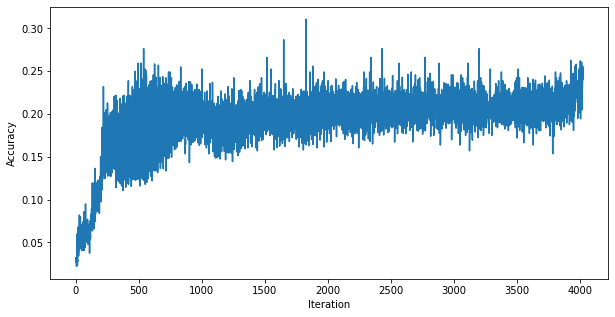

In [43]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

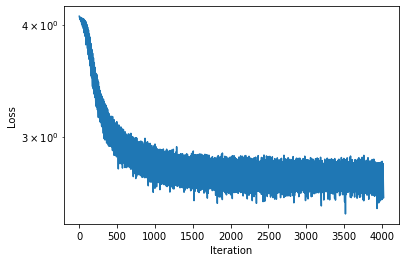

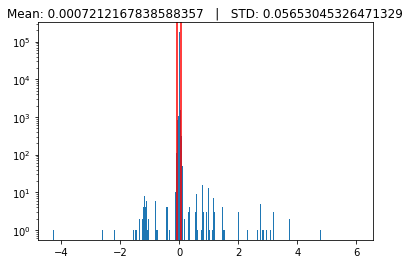

In [44]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 8.561797752808989


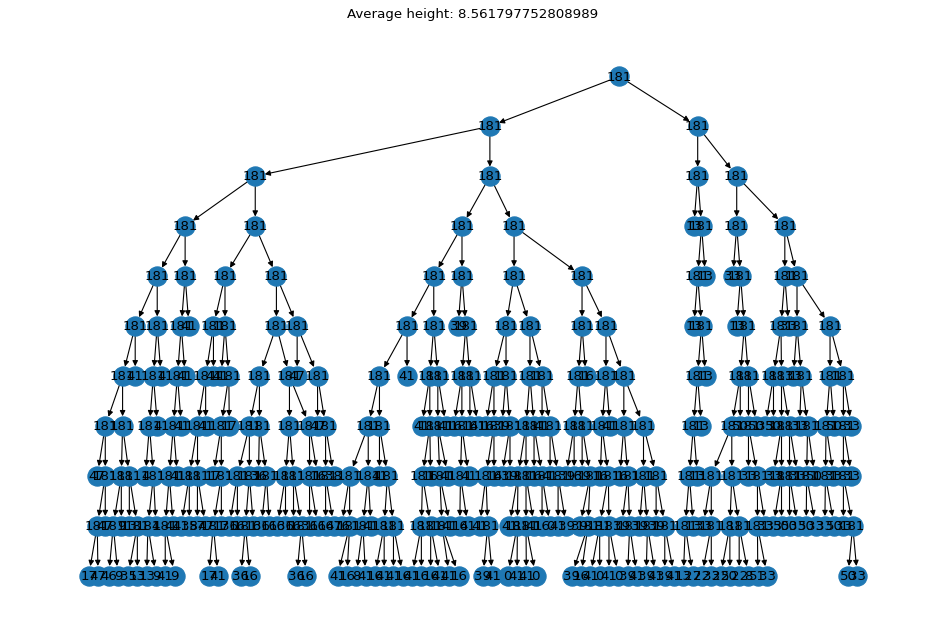

In [47]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [48]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 178


In [49]:
method = 'MLE'

In [50]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [51]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))
/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()